In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
import statsmodels.api as sm
from scipy import stats
from concurrent.futures import ThreadPoolExecutor

In [2]:
fomc_data = pd.read_excel("MPshocksAcosta.xlsx", sheet_name="shocks")

In [3]:
fomc_data.head()

,fomc,ns,target,path,ff.shock.0
0,1995-02-01,1.163436,1.546758,0.264185,0.062222
1,1995-03-28,0.755648,0.719967,0.537239,-0.010000
2,1995-05-23,0.011665,0.102324,-0.065620,0.000000
3,1995-07-06,-4.719216,-2.750982,-3.921459,-0.099200
4,1995-08-22,1.039980,1.295761,0.240067,0.068889


In [4]:
fomc_data.dtypes

fomc          datetime64[ns]
ns                   float64
target               float64
path                 float64
ff.shock.0           float64
dtype: object

### 1. Understanding Monetary Policy Surprises

In [5]:
fomc_data[['target','path']].describe()

,target,path
count,2.210000e+02,2.210000e+02
mean,-8.037814e-18,6.028360e-18
std,1.000000e+00,1.000000e+00
min,-4.955137e+00,-3.921459e+00
25%,-1.063866e-01,-3.751414e-01
50%,7.149114e-02,7.268609e-02
75%,2.520131e-01,4.126043e-01
max,3.232849e+00,3.992300e+00


-   Standardized Data:

    -   Both the "target" and "path" factors have been standardized.
    -   This is evident from their mean values being close to 0 and a standard deviation of 1.
-   Median Values:

    -   The medians for both factors are close to zero.
    -   This indicates a balance in the dataset, with roughly equal numbers of positive and negative surprises.
-   Range of Values:

    -   There's a wide range observed between the minimum and maximum values for both the "target" and "path" factors.
    -   This suggests that the magnitude of monetary policy surprises has varied significantly over the time period in the dataset.
-   Implication:

    -   The variability in the surprises indicates that FOMC announcements have had varying levels of unexpectedness over the years.
    -   This could be due to changing economic conditions, policy shifts, or market perceptions of the FOMC's decision-making process.

## Finding the Zero Lower Bound Period in the given timeline

In [6]:
# Reading the data from the CSV into a dataframe
fed_funds_data = pd.read_csv("current.csv")
fed_funds_data = fed_funds_data.tail(-1)
fed_funds_data["sasdate"] = pd.to_datetime(fed_funds_data["sasdate"])

In [7]:
fed_funds_data[["sasdate","FEDFUNDS"]].head()

,sasdate,FEDFUNDS
1,1959-01-01,2.48
2,1959-02-01,2.43
3,1959-03-01,2.80
4,1959-04-01,2.96
5,1959-05-01,2.90


### Note: I've chosen the 0.25% threshold as the Zero Lower Bound (ZLB) based on historical context, specifically referencing the Federal Open Market Committee (FOMC) which set the federal funds rate target range at 0 to 0.25 percent during the 2007-2009 financial crisis, underscoring its perspective on the effective lower bound (Federal Reserve, FOMC statement, December 16, 2008)

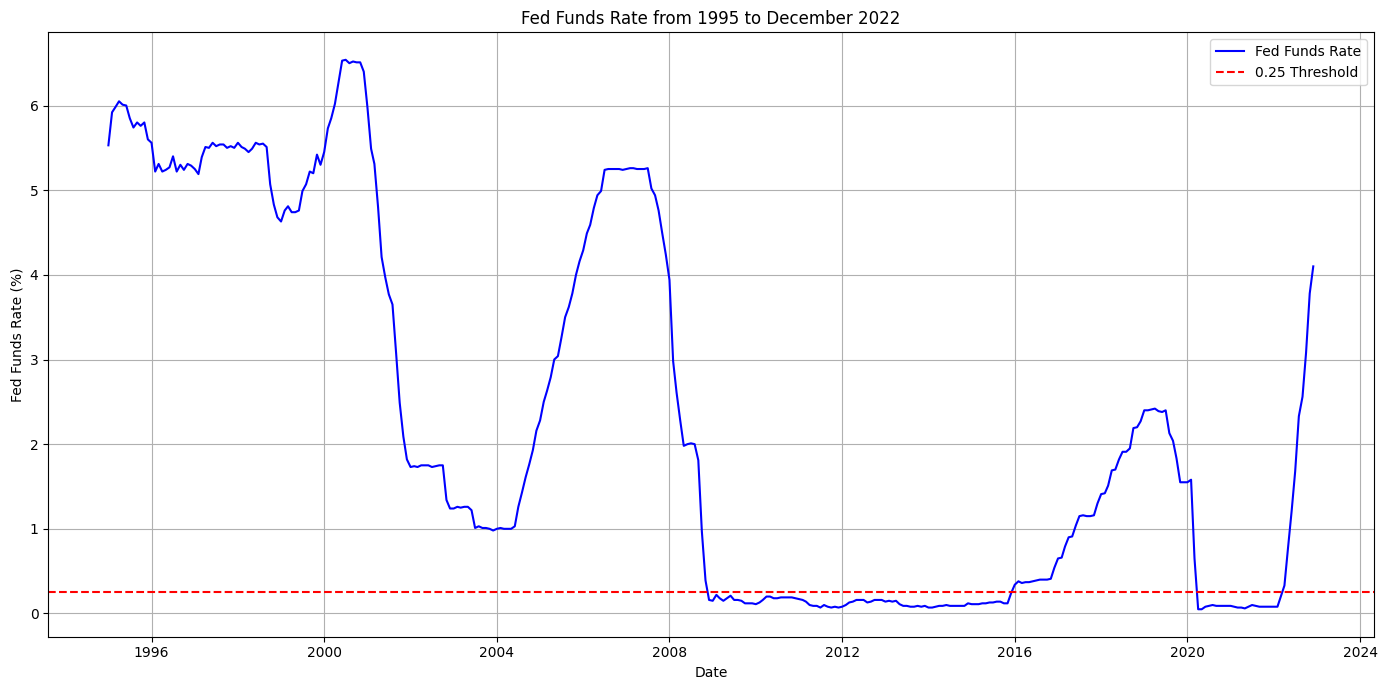

In [8]:
# Filtering the fed_funds_data for the period from 1995 to December 2022
fed_funds_data_filtered = fed_funds_data[(fed_funds_data['sasdate'] >= '1995-01-01') & (fed_funds_data['sasdate'] <= '2022-12-31')]

# Plotting the Fed Funds Rate over the specified period
plt.figure(figsize=(14, 7))
plt.plot(fed_funds_data_filtered['sasdate'], fed_funds_data_filtered['FEDFUNDS'], label='Fed Funds Rate', color='blue')
plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 Threshold')
plt.title('Fed Funds Rate from 1995 to December 2022')
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Identifying the first instance of the drop below 0.25% after 2008 and before 2016
zlb_period_post_2008 = fed_funds_data_filtered[(fed_funds_data_filtered['sasdate'] > '2008-01-01') & (fed_funds_data_filtered['FEDFUNDS'] <= 0.25) & (fed_funds_data_filtered['sasdate'] < '2016-01-01')]

# Extracting the start and end dates for this ZLB period
zlb_start_date_post_2008 = zlb_period_post_2008['sasdate'].min()
zlb_end_date_post_2008 = zlb_period_post_2008['sasdate'].max()

zlb_start_date_post_2008, zlb_end_date_post_2008


(Timestamp('2008-12-01 00:00:00'), Timestamp('2015-12-01 00:00:00'))

In [10]:
# Filtering the fomc_data based on the ZLB period identified (Dec 2008 to Dec 2015)
fomc_data_zlb_post_2008 = fomc_data[(fomc_data['fomc'] >= zlb_start_date_post_2008) & (fomc_data['fomc'] <= zlb_end_date_post_2008)]

# Computing the descriptive statistics for the "target" and "path" columns during this ZLB period
fomc_data_zlb_post_2008[["target","path"]].describe()

,target,path
count,56.000000,56.000000
mean,-0.009459,-0.081597
std,0.623150,0.723363
min,-4.210779,-2.491452
25%,-0.002392,-0.252802
50%,0.083020,0.067644
75%,0.145645,0.237196
max,0.500636,1.239213


### For the period December 1, 2008, to December 1, 2015:

-   Target Factor: The "target" factor had a mean slightly negative at -0.0095, suggesting a slight negative surprise on average during this period. The spread between the minimum (-4.2108) and the maximum (0.5006) values highlights significant variability in monetary policy surprises, with more pronounced negative surprises.

-   Path Factor: The mean for the "path" factor was -0.0816, indicating that the market's perception of future policy rates was more often revised downwards during this period. The larger standard deviation (0.7234) compared to the "target" factor suggests greater variability in the market's perception of future policy moves.

In [11]:
zlb_period_post_2020 = fed_funds_data_filtered[(fed_funds_data_filtered['sasdate'] > '2020-01-01') & (fed_funds_data_filtered['FEDFUNDS'] <= 0.25)]

# Extracting the start and end dates for this ZLB period
zlb_start_date_post_2020 = zlb_period_post_2020['sasdate'].min()
zlb_end_date_post_2020 = zlb_period_post_2020['sasdate'].max()

zlb_start_date_post_2020, zlb_end_date_post_2020

(Timestamp('2020-04-01 00:00:00'), Timestamp('2022-03-01 00:00:00'))

In [12]:
# Filtering the fomc_data based on the ZLB period identified (April 2020 to March 2022)
fomc_data_zlb_post_2020 = fomc_data[(fomc_data['fomc'] >= zlb_start_date_post_2020) & (fomc_data['fomc'] <= zlb_end_date_post_2020)]

# Computing the descriptive statistics for the "target" and "path" columns during this ZLB period
fomc_data_zlb_post_2020[["target","path"]].describe()

,target,path
count,15.000000,15.000000
mean,-0.011412,0.170522
std,0.251489,0.261883
min,-0.748082,-0.112056
25%,-0.047709,0.038261
50%,-0.022170,0.106872
75%,0.092805,0.193700
max,0.426747,0.962592


### For the period April 1, 2020, to March 1, 2022:

-   Target Factor: The "target" factor had a mean value close to zero (-0.0114), suggesting balanced positive and negative surprises in the current policy setting. However, the presence of a significant negative minimum value (-0.7481) indicates there were instances of notable negative monetary policy surprises.

-   Path Factor: With a positive mean (0.1705), the "path" factor suggests that the market, on average, revised its expectations of future policy rates upwards. This is reinforced by the maximum value of 0.9626, indicating strong positive surprises regarding forward guidance during certain times in this period.

### 2. Link between Monetary Policy Surprises and Economic Indicators

## 2.1 Group-1 INDPRO (Industrial Production Index) Vs Monetary Policy Surprises

- I have chosen the INDPRO (Industrial Production Index) as a key economic indicator from Group 1 to analyze the effects of monetary policy shocks. My rationale for this selection is rooted in the extensive research on the transmission mechanisms of monetary policy and its impact on various facets of the economy. Christiano, Eichenbaum, and Evans (1999) emphasize the significant role of industrial production in reflecting the immediate and persistent effects of monetary policy shocks. Their findings indicate that a contractionary monetary policy shock, for instance, leads to a sustained decline in industrial production, highlighting the sensitivity and relevance of this indicator in gauging policy impacts.

- Reference: Christiano, L. J., Eichenbaum, M., & Evans, C. L. (1999). Monetary Policy Shocks: What Have We Learned and to What End? In J. B. Taylor & M. Woodford (Eds.), Handbook of Macroeconomics (Vol. 1, Part A, pp. 65-148). Elsevier.

In [13]:
macro_data = pd.read_csv("current.csv")
macro_data = macro_data.tail(-1)
macro_data["sasdate"] = pd.to_datetime(macro_data["sasdate"])

In [14]:
group_1_data = macro_data[["sasdate","INDPRO"]]

In [15]:
group_1_data.head()

,sasdate,INDPRO
1,1959-01-01,21.9665
2,1959-02-01,22.3966
3,1959-03-01,22.7193
4,1959-04-01,23.2032
5,1959-05-01,23.5528


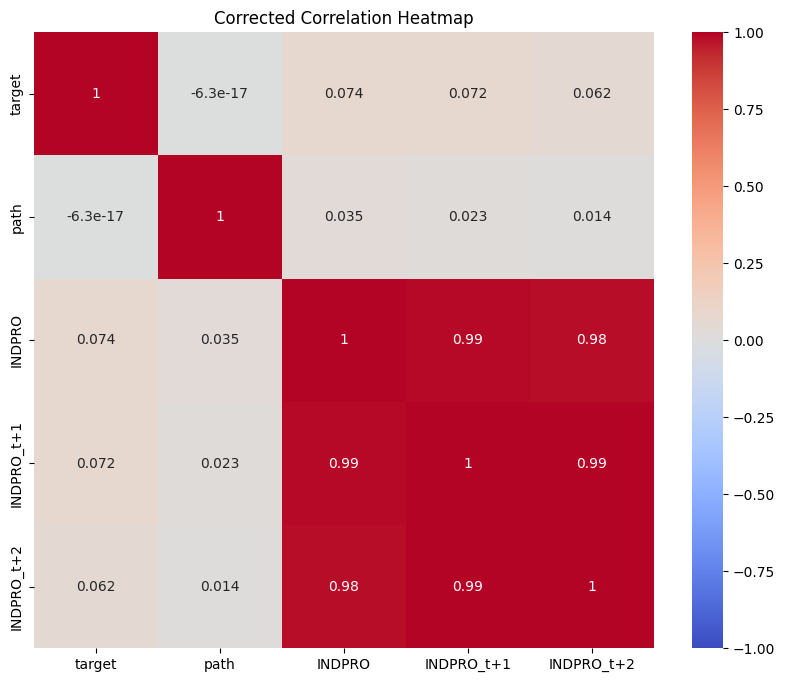

,target,path,INDPRO,INDPRO_t+1,INDPRO_t+2
target,1.000000e+00,-6.257621e-17,0.073628,0.072490,0.061958
path,-6.257621e-17,1.000000e+00,0.034917,0.023101,0.014218
INDPRO,7.362755e-02,3.491715e-02,1.000000,0.989583,0.978433
INDPRO_t+1,7.248979e-02,2.310071e-02,0.989583,1.000000,0.994994
INDPRO_t+2,6.195760e-02,1.421773e-02,0.978433,0.994994,1.000000


In [16]:
# Creating correct leadd versions of INDPRO for t+1 and t+2
group_1_data.loc[:, 'INDPRO_t+1'] = group_1_data['INDPRO'].shift(1)
group_1_data.loc[:, 'INDPRO_t+2'] = group_1_data['INDPRO'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_1_data.loc[:, 'year_month'] = group_1_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_1_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'INDPRO', 'INDPRO_t+1', 'INDPRO_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1\. INDPRO vs. Target Rate (Monetary Policy Decisions)

-   The correlation between INDPRO and the target rate in the same month (t) is approximately 0.0736. This suggests a positive but mild relationship between the two. As the target rate (often set by the central bank to manage inflation and economic growth) rises, it can be inferred that there's a slight increase in industrial production.
-   The correlation between INDPRO in the following month (t+1) and the target rate is 0.0725, and for two months later (t+2), it is 0.0620. These figures indicate that the effect of the target rate on industrial production diminishes slightly over time but remains positive.

2\. INDPRO vs. Path of Future Rates (Expected Monetary Policy Trajectory)

-   The correlation between INDPRO and the path in the month of t is 0.0349, indicating a weaker positive relationship than with the target rate. This suggests that the expected trajectory of future monetary policy rates has a milder immediate impact on industrial production.
-   The correlation for t+1 and t+2 are 0.0231 and 0.0142 respectively, which signifies that the impact of expected future monetary policy on industrial production further diminishes over the subsequent months.

Economic Insights:

-   Immediate Reactions: The Industrial Production Index shows an immediate positive reaction to the monetary policy's target rate. This could be due to the fact that when the central bank sets a higher target rate, it signals confidence in the economy, leading industries to ramp up production in anticipation of increased demand.

-   Anticipating the Future: The path, or the expected trajectory of future rates, has a more muted impact on industrial production. This might be due to the inherent uncertainties involved in forecasting, causing industries to be more reactive to present conditions (target rate) than speculative ones (path).

-   Persistence of Effects: The diminishing correlations over t+1 and t+2 for both target and path with INDPRO suggest that the impacts of monetary policy decisions and expectations on industrial production are more immediate and tend to wane as time progresses.

## 2.1 Group-1 RPI (Real Personal Income) Vs Monetary Policy Surprises

### Note: -   As per Mishkin (2007), Real Personal Income represents the inflation-adjusted total income of individuals. It's highlighted that shifts in monetary policy, especially interest rate adjustments, can significantly sway consumer borrowing and expenditure behaviors. For instance, when monetary policy eases, we might witness an upsurge in consumer spending, which can potentially elevate real personal income. This underscores the sensitivity of RPI to monetary policy dynamics and its utility as an economic indicator.

Reference: Mishkin, F. S. (2007). The Economics of Money, Banking, and Financial Markets. Pearson Education.

In [17]:
group_1_data = macro_data[["sasdate","RPI"]]

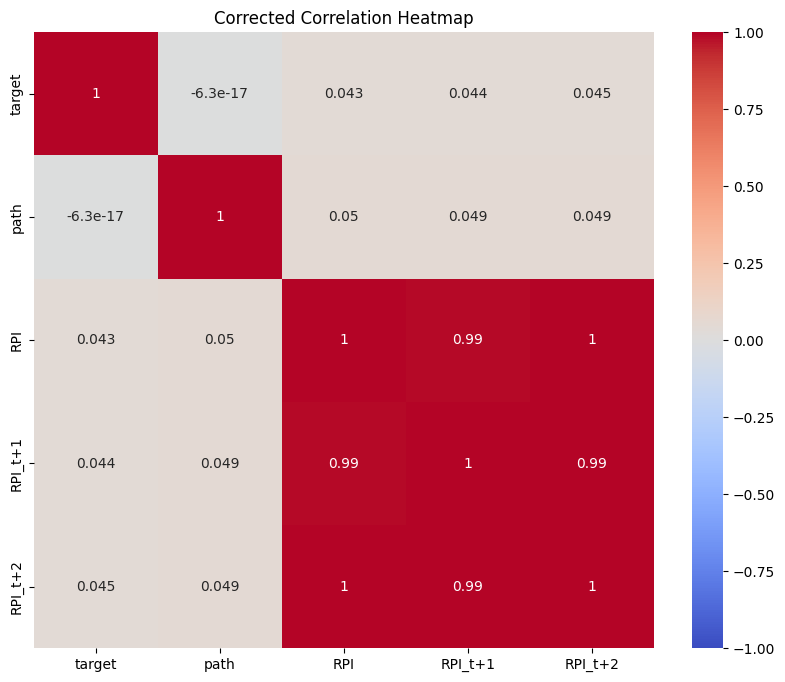

,target,path,RPI,RPI_t+1,RPI_t+2
target,1.000000e+00,-6.257621e-17,0.042771,0.044312,0.044772
path,-6.257621e-17,1.000000e+00,0.049935,0.049177,0.048705
RPI,4.277131e-02,4.993474e-02,1.000000,0.990380,0.995516
RPI_t+1,4.431172e-02,4.917724e-02,0.990380,1.000000,0.994320
RPI_t+2,4.477244e-02,4.870540e-02,0.995516,0.994320,1.000000


In [18]:
# Creating correct lead versions of RPI for t+1 and t+2
group_1_data.loc[:, 'RPI_t+1'] = group_1_data['RPI'].shift(1)
group_1_data.loc[:, 'RPI_t+2'] = group_1_data['RPI'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_1_data.loc[:, 'year_month'] = group_1_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_1_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'RPI', 'RPI_t+1', 'RPI_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1\. RPI vs. Target Rate (Monetary Policy Decisions)

-   The correlation between RPI and the target rate for the month t is approximately 0.0428. This suggests a positive but mild relationship. A rise in the target rate, often indicative of a central bank's response to strong economic conditions, might be associated with an increase in the real personal income.

-   For the subsequent months t+1 and t+2, the correlations are 0.0443 and 0.0448 respectively. This indicates that the relationship between RPI and the target rate remains fairly consistent over a three-month period.

2\. RPI vs. Path of Future Rates (Expected Monetary Policy Trajectory)

-   The correlation between RPI and the path in the month t is 0.0499, slightly stronger than its relationship with the target rate. This hints that expected future monetary policy decisions might have a more pronounced immediate impact on real personal income.

-   The correlations for t+1 and t+2 are 0.0492 and 0.0487, indicating a minor decrease in the relationship's strength. This could be because as time progresses, other economic factors come into play, slightly overshadowing the influence of the expected policy trajectory on RPI.

Economic Insights:

-   Monetary Policy's Impact on Income: The positive correlations suggest that as the central bank signals a strengthening economy through its decisions (target rate) and expectations (path), there's a corresponding uptick in real personal income. This might be due to increased employment opportunities, wage hikes, or dividends from investments in a booming economy.

-   Consistent Influence Over Time: The fairly stable correlations across t, t+1, and t+2 imply that the effects of monetary policy on real personal income persist over at least a quarter. This showcases the lasting impact of monetary policy signals on consumer financial health.

-   Expectations Matter: The slightly stronger correlation of RPI with the path as compared to the target rate underscores the significance of future monetary policy expectations. It highlights the role of forward guidance in influencing consumer sentiment and financial behavior.

## 2.2 Group-2 UNRATE (Civilian Unemployment Rate) Vs Monetary Policy Surprises

- I've chosen the UNRATE (Civilian Unemployment Rate) as a pivotal labor market indicator from Group 2 to delve into the repercussions of monetary policy surprises. This decision is anchored in the comprehensive work by Bernanke and Blinder (1992), who underscore the direct link between monetary policy maneuvers and labor market dynamics. They elucidate that contractionary monetary policy interventions can precipitate an uptick in unemployment rates. This underscores the immediacy and potency of UNRATE as a barometer to detect swift reactions to unforeseen monetary policy shifts.

- Reference: Bernanke, B. S., & Blinder, A. S. (1992). The federal funds rate and the channels of monetary transmission. *The American Economic Review*, 901-921.

In [19]:
group_2_data = macro_data[["sasdate","UNRATE"]]

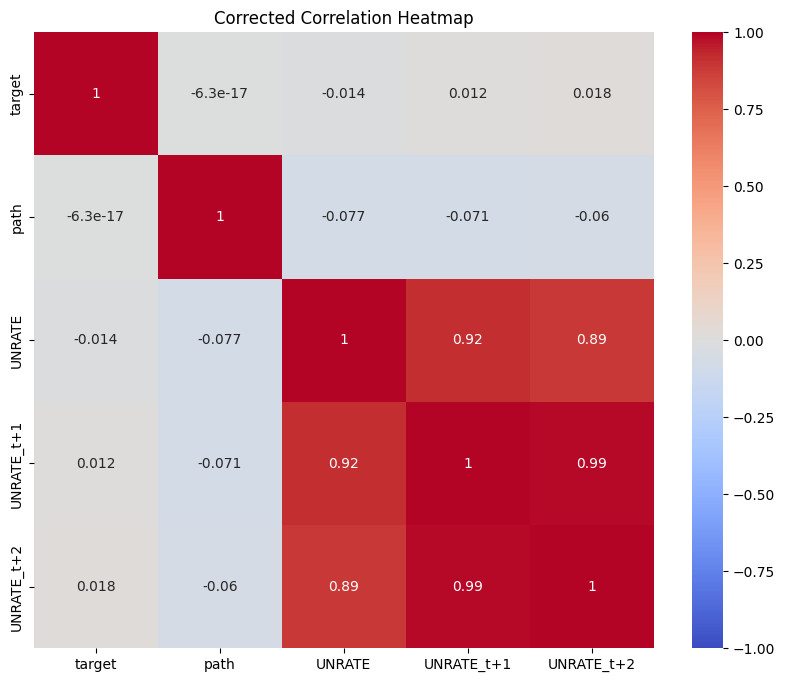

,target,path,UNRATE,UNRATE_t+1,UNRATE_t+2
target,1.000000e+00,-6.257621e-17,-0.013734,0.012407,0.017846
path,-6.257621e-17,1.000000e+00,-0.076861,-0.070861,-0.059563
UNRATE,-1.373369e-02,-7.686104e-02,1.000000,0.918321,0.887993
UNRATE_t+1,1.240703e-02,-7.086115e-02,0.918321,1.000000,0.989002
UNRATE_t+2,1.784581e-02,-5.956305e-02,0.887993,0.989002,1.000000


In [20]:
group_2_data.loc[:, 'UNRATE_t+1'] = group_2_data['UNRATE'].shift(1)
group_2_data.loc[:, 'UNRATE_t+2'] = group_2_data['UNRATE'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_2_data.loc[:, 'year_month'] = group_2_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_2_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'UNRATE', 'UNRATE_t+1', 'UNRATE_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1\. UNRATE vs. Target Rate (Monetary Policy Decisions)

-   The correlation between UNRATE and the target rate for the month t is approximately -0.0137. This is a negative but very mild relationship, suggesting that a rise in the target rate might be very faintly associated with a decrease in the unemployment rate. However, this relationship is almost negligible.

-   For the subsequent months t+1 and t+2, the correlations are 0.0124 and 0.0178 respectively, indicating a slight positive relationship between leading unemployment and the target rate.

2\. UNRATE vs. Path of Future Rates (Expected Monetary Policy Trajectory)

-   The correlation between UNRATE and the path in the month t is -0.0769, suggesting that when the central bank signals a likely tightening of monetary policy in the future, there's a more noticeable decrease in the unemployment rate.

-   The correlations for t+1 and t+2 are -0.0709 and -0.0596, indicating that the relationship's strength diminishes slightly over time.

Economic Insights:

-   Monetary Policy's Impact on Employment: The negative correlation between the unemployment rate and the path suggests that as the central bank signals tighter future monetary conditions, it might correspond with improved employment conditions. This could be because the central bank's expectations of future economic tightening are based on the current robust economic performance, which typically coincides with lower unemployment.

-   Persisting Influence of Unemployment: The strong positive correlations between UNRATE at time t and its subsequent lags (around 0.918 for t vs t+1 and 0.988 for t+1 vs t+2) demonstrate the persistence of unemployment rates over time. This highlights the inertial nature of labor markets.

-   Expectations and Labor Markets: The more pronounced negative correlation between UNRATE and the path as compared to the target rate underscores the idea that future monetary policy expectations play a pivotal role in influencing labor market conditions.

## 2.2 Group 2 CLAIMSx(Unemployment Claims) Vs Monetary Policy Surprises

- I have chosen the `CLAIMSx` (Initial Unemployment Claims) as an essential labor market indicator from Group 2 to investigate the effects of monetary policy shocks. My decision to focus on this variable is underpinned by a plethora of research that underscores the sensitivity and immediacy of initial unemployment claims in response to economic changes. Initial unemployment claims serve as a leading indicator, providing real-time insights into the health of the labor market. In their study, Stock and Watson (1989) identified initial unemployment claims as one of several key leading indicators that provide valuable forecasting information for economic downturns. This indicator's high frequency and timeliness make it particularly relevant for analyzing the immediate effects of monetary policy shocks, as changes in the labor market conditions can be swiftly captured through fluctuations in unemployment claims.

-   Reference: Stock, J. H., & Watson, M. W. (1989). New Indexes of Coincident and Leading Economic Indicators. In NBER Macroeconomics Annual 1989, Volume 4 (pp. 351-394). MIT Press.

In [21]:
group_2_data = macro_data[["sasdate","CLAIMSx"]]

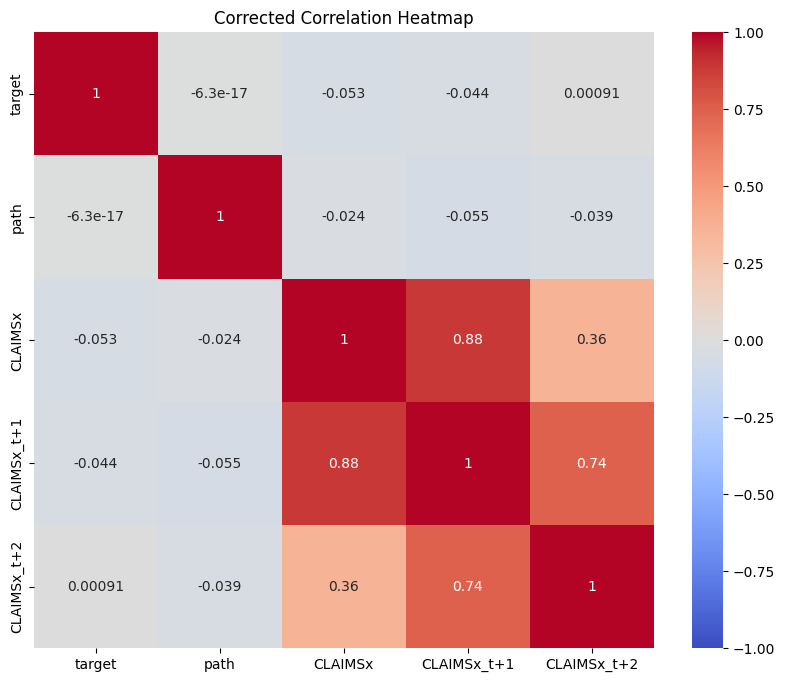

,target,path,CLAIMSx,CLAIMSx_t+1,CLAIMSx_t+2
target,1.000000e+00,-6.257621e-17,-0.052926,-0.044148,0.000909
path,-6.257621e-17,1.000000e+00,-0.024104,-0.054777,-0.039121
CLAIMSx,-5.292615e-02,-2.410356e-02,1.000000,0.883979,0.361381
CLAIMSx_t+1,-4.414758e-02,-5.477732e-02,0.883979,1.000000,0.742801
CLAIMSx_t+2,9.088167e-04,-3.912077e-02,0.361381,0.742801,1.000000


In [22]:
group_2_data.loc[:, 'CLAIMSx_t+1'] = group_2_data['CLAIMSx'].shift(1)
group_2_data.loc[:, 'CLAIMSx_t+2'] = group_2_data['CLAIMSx'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_2_data.loc[:, 'year_month'] = group_2_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_2_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'CLAIMSx', 'CLAIMSx_t+1', 'CLAIMSx_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1\. CLAIMSx vs. Target Rate (Monetary Policy Decisions)

-   The correlation between `CLAIMSx` and the target rate for month t is -0.0529. This indicates a modest negative relationship, suggesting that a rise in the target rate might be associated with a decrease in unemployment claims.

-   For the subsequent months t+1 and t+2, the correlations are -0.0441 and 0.0009 respectively. This means the relationship weakens slightly over time and becomes almost negligible by t+2.

2\. CLAIMSx vs. Path of Future Rates (Expected Monetary Policy Trajectory)

-   The correlation between `CLAIMSx` and the path in month t is -0.0241, suggesting a mild negative relationship. This indicates that when there's an expectation of future monetary policy tightening, there might be a slight decrease in unemployment claims.

-   The correlations for t+1 and t+2 are -0.0548 and -0.0391, indicating that the relationship remains mildly negative over time.

Economic Insights:

-   Monetary Policy and Job Security: The negative correlation between unemployment claims and both the target rate and the path could be interpreted as a sign of increased job security when there's an anticipation of monetary tightening. This is because tightening often comes as a response to an overheated economy, where job security is higher and unemployment claims decrease.

-   Lead Impact on Labor Market: The consistently negative correlations between unemployment claims and monetary policy variables, even at lags, suggest that the effects of monetary policy on the labor market are persistent and do not dissipate immediately.

-   Persistence in Unemployment Claims: The strong positive correlations between `CLAIMSx` at time t and its subsequent months (0.884 for t vs t+1 and 0.743 for t+1 vs t+2) highlight the inertia in unemployment claims, indicating that labor market conditions do not change rapidly from month to month.

## 2.3 Group 3 HOUST (Housing Starts) Vs Monetary Policy Surprises

- I've chosen the Housing Starts as a pivotal economic indicator from Group 3. Housing starts are a leading indicator for the real estate sector, offering insights into future real estate supply levels. The rationale behind this selection is grounded in the extensive literature on the significance of housing in the U.S. economy. Following a monetary policy shock, housing starts can be particularly sensitive. For instance, an expansionary monetary policy, which typically results in lower interest rates, can stimulate borrowing and thus lead to an uptick in housing starts as it becomes cheaper for consumers and developers to finance new construction projects. Conversely, a contractionary policy can suppress housing starts as borrowing costs rise.

- Reference: Leamer, E. E. (2007). Housing is the business cycle. In Proceedings - Economic Policy Symposium - Jackson Hole (pp. 149-233). Federal Reserve Bank of Kansas City.

In [23]:
group_3_data = macro_data[["sasdate","HOUST"]]

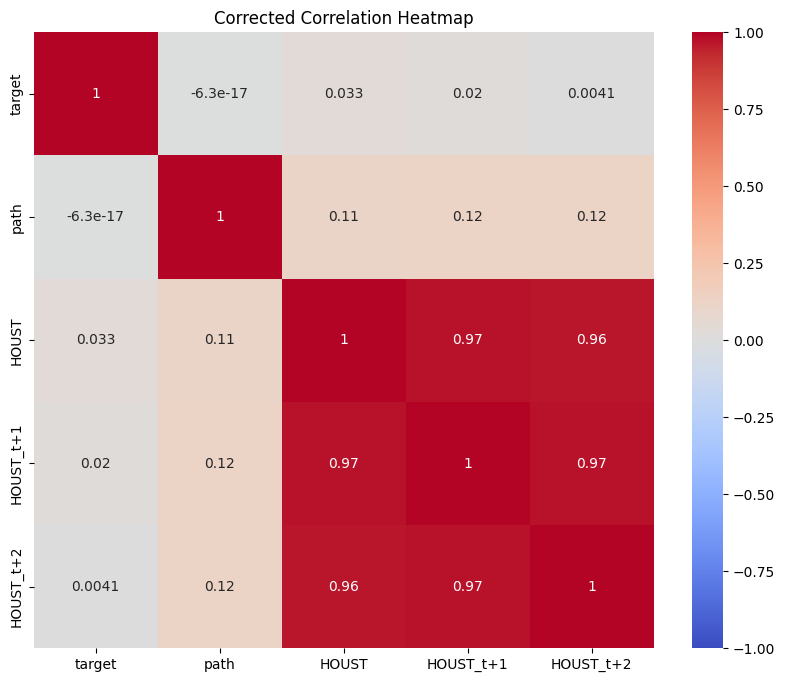

,target,path,HOUST,HOUST_t+1,HOUST_t+2
target,1.000000e+00,-6.257621e-17,0.033251,0.019853,0.004084
path,-6.257621e-17,1.000000e+00,0.110946,0.119509,0.122434
HOUST,3.325053e-02,1.109457e-01,1.000000,0.970304,0.962044
HOUST_t+1,1.985328e-02,1.195087e-01,0.970304,1.000000,0.974775
HOUST_t+2,4.083851e-03,1.224337e-01,0.962044,0.974775,1.000000


In [24]:
group_3_data.loc[:, 'HOUST_t+1'] = group_3_data['HOUST'].shift(1)
group_3_data.loc[:, 'HOUST_t+2'] = group_3_data['HOUST'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_3_data.loc[:, 'year_month'] = group_3_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_3_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'HOUST', 'HOUST_t+1', 'HOUST_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1\. HOUST vs. Target Rate (Monetary Policy Decisions)

-   The correlation between `HOUST` and the target rate for month t stands at 0.0333. This indicates a slight positive relationship, suggesting that a rise in the target rate might be associated with a modest increase in housing starts.

-   For the subsequent months t+1 and t+2, the correlations diminish to 0.0199 and 0.0041, respectively. This suggests that the impact of the target rate on housing starts becomes less pronounced over time.

2\. HOUST vs. Path of Future Rates (Expected Monetary Policy Trajectory)

-   The correlation between `HOUST` and the path in month t is 0.1109. This suggests a moderate positive relationship, meaning that when there's an expectation of future monetary policy tightening, housing starts tend to increase moderately.

-   The correlations for t+1 and t+2 are 0.1195 and 0.1224, respectively. This indicates that the relationship strengthens slightly over time.

Economic Insights:

-   Monetary Policy and Housing Market: The positive correlation between housing starts and both the target rate and the path suggests that when there's an anticipation of tighter monetary policy, there might be an increase in housing starts. This could be driven by the anticipation of higher borrowing costs in the future, prompting builders to initiate more projects before rates rise.

-   Housing Market Dynamics: The consistently positive correlations between housing starts and monetary policy variables even at lags underscore the idea that the housing market responds to monetary policy cues over an extended period.

-   Persistence in Housing Starts: The robust positive correlations between `HOUST` at time t and its subsequent months (0.9703 for t vs t+1 and 0.9748 for t+1 vs t+2) showcase the momentum in housing starts, indicating that trends in the housing market tend to persist from month to month.

## 2.4 Group 4  ISM : PMI Composite Index (PMI) Vs Monetary Policy Surprises 

- I've chosen the Total Business Inventories (BUSINVx) from Group 4 as a key economic metric. Business inventories represent goods that have been produced but not yet sold, making them a vital indicator of the balance between production and consumption in the economy. My rationale for focusing on business inventories is rooted in the substantial body of literature that underscores the inventory cycle's role in economic fluctuations and its interplay with monetary policy. Following a monetary policy shock, the response of business inventories can be telling. For example, an expansionary monetary policy might lead firms to ramp up their inventories in anticipation of increased consumer demand, buoyed by easier borrowing conditions. In contrast, a contractionary policy might see firms reduce inventory accumulation, expecting muted demand due to higher borrowing costs.

-   Reference: Blinder, A. S., & Maccini, L. J. (1991). The Resurgence of Inventory Research: What Have We Learned? Journal of Economic Surveys, 5(4), 291-328. This work delves into the dynamics of inventory management, its implications for business cycles, and its sensitivity to monetary policy shifts.

In [25]:
group_4_data = macro_data[["sasdate","BUSINVx"]]

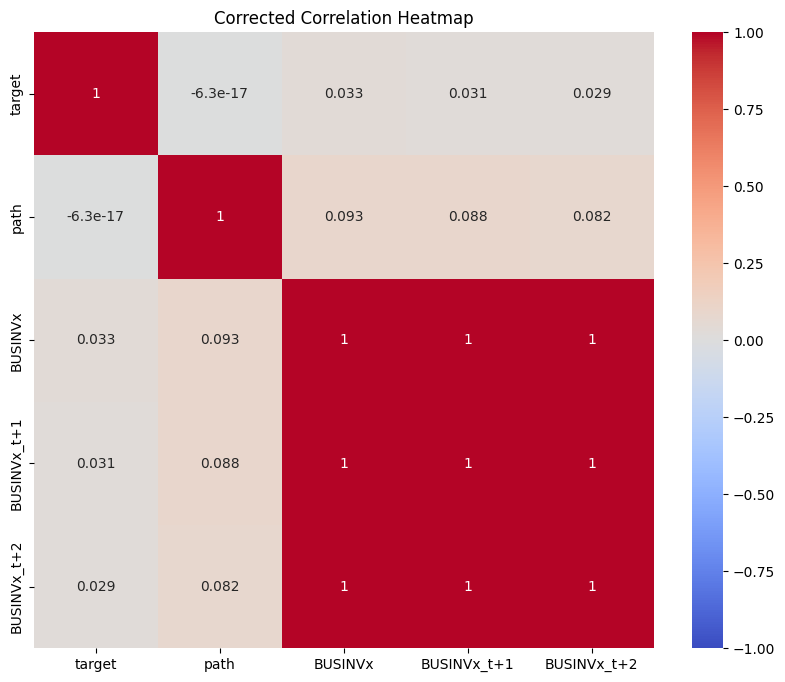

,target,path,BUSINVx,BUSINVx_t+1,BUSINVx_t+2
target,1.000000e+00,-6.257621e-17,0.032574,0.030851,0.029374
path,-6.257621e-17,1.000000e+00,0.092970,0.087726,0.082083
BUSINVx,3.257433e-02,9.296958e-02,1.000000,0.999681,0.998844
BUSINVx_t+1,3.085053e-02,8.772553e-02,0.999681,1.000000,0.999664
BUSINVx_t+2,2.937398e-02,8.208278e-02,0.998844,0.999664,1.000000


In [26]:
group_4_data.loc[:, 'BUSINVx_t+1'] = group_4_data['BUSINVx'].shift(1)
group_4_data.loc[:, 'BUSINVx_t+2'] = group_4_data['BUSINVx'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_4_data.loc[:, 'year_month'] = group_4_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_4_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'BUSINVx', 'BUSINVx_t+1', 'BUSINVx_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1.  Moderate Sensitivity to Monetary Policy Shocks: Both the 'target' and 'path' variables exhibit a positive correlation with the business inventories (BUSINVx) and its subsequent lags (BUSINVx_t+1 and BUSINVx_t+2). While the correlation coefficients are not exceedingly high, they are notable. This suggests that business inventories tend to move in the same direction as the FOMC's monetary policy decisions, albeit moderately. This aligns with the understanding that an expansionary policy (like a rate cut) might encourage firms to increase inventories in anticipation of bolstered consumer demand, while a contractionary policy might have the opposite effect.

2.  High Persistence in Business Inventories: The business inventories data show strong positive correlations with their own lags. Particularly, the correlation between BUSINVx and its first lag (BUSINVx_t+1) is almost perfectly positive, indicating a high level of persistence. This suggests that changes in business inventories tend to carry over strongly from one month to the next, reflecting the gradual nature of inventory adjustments.

3.  Lead gged Response to Monetary Policy: The correlation between the 'path' variable and the business inventories increases slightly as we move from the current period to the first lag (BUSINVx_t+1), indicating that the effect of monetary policy on inventories might be slightly leadig. This is consistent with the idea that firms might take some time to adjust their inventory levels in response to policy shifts.

### 2.5 Group 5 BUSLOANS Vs Monteary Policy Suprises

- I've opted for Commercial and Industrial Loans (BUSLOANS) as a salient metric from Group 5, focusing on Money and Credit. These loans play a pivotal role in gauging the influence of monetary policy on real economic activities, especially through the bank lending channel. An expansionary monetary policy, characterized by lower interest rates, generally boosts these loans, as it becomes more cost-effective for firms to borrow for investments and operational expansion. Conversely, a contractionary policy stance, resulting in elevated interest rates, can stifle the growth of such loans.

- Kashyap and Stein (2000) offer profound insights into this dynamic. They assert that monetary policy, through its influence on bank reserves and liquidity conditions, can significantly impact bank lending, particularly commercial and industrial loans. Their research demonstrates that smaller banks, which are often more reliant on deposits for funding, exhibit more pronounced fluctuations in their lending behavior in response to monetary policy changes compared to larger banks. Such nuances underline the importance of tracking commercial and industrial loans as they can provide nuanced insights into the varied impacts of monetary policy across the banking sector and, by extension, the broader economy.

-   Reference: Kashyap, A. K., & Stein, J. C. (2000). What Do a Million Observations on Banks Say about the Transmission of Monetary Policy? The American Economic Review, 90(3), 407-428.

In [27]:
group_5_data = macro_data[["sasdate","BUSLOANS"]]

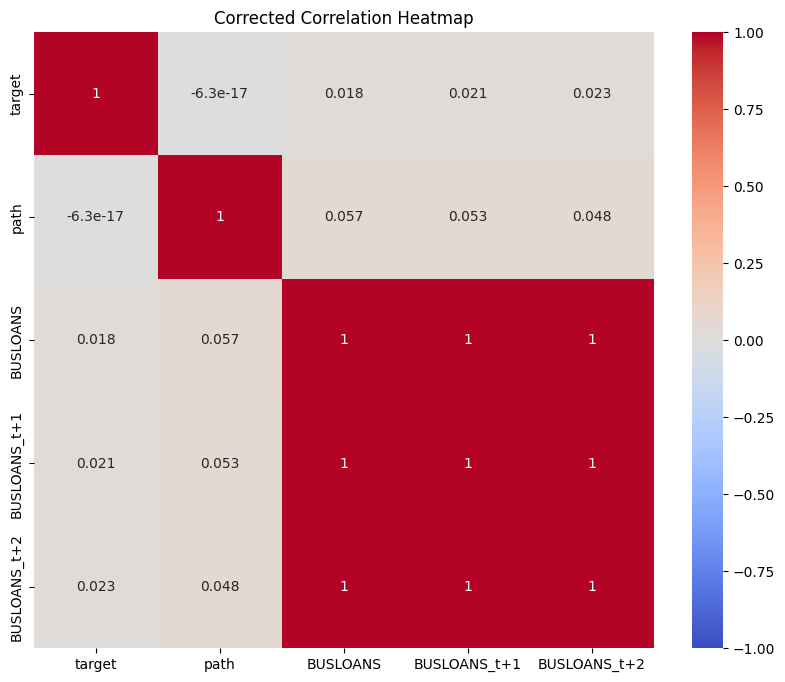

,target,path,BUSLOANS,BUSLOANS_t+1,BUSLOANS_t+2
target,1.000000e+00,-6.257621e-17,0.018147,0.021347,0.023433
path,-6.257621e-17,1.000000e+00,0.056794,0.052870,0.048382
BUSLOANS,1.814747e-02,5.679418e-02,1.000000,0.998698,0.996396
BUSLOANS_t+1,2.134736e-02,5.287022e-02,0.998698,1.000000,0.999183
BUSLOANS_t+2,2.343294e-02,4.838207e-02,0.996396,0.999183,1.000000


In [28]:
group_5_data.loc[:, 'BUSLOANS_t+1'] = group_5_data['BUSLOANS'].shift(1)
group_5_data.loc[:, 'BUSLOANS_t+2'] = group_5_data['BUSLOANS'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_5_data.loc[:, 'year_month'] = group_5_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_5_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'BUSLOANS', 'BUSLOANS_t+1', 'BUSLOANS_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1.  Contemporaneous Correlation with FOMC Variables: The immediate correlation between "target" or "path" and "BUSLOANS" is relatively weak. This indicates that the immediate influence of monetary policy on commercial and industrial loans is subdued, perhaps due to the anticipation and gradual nature of banks' reactions to policy changes.

2.  Anticipatory Effects: The correlations with the leading values of BUSLOANS (t+1​ and t+2​) suggest that banks might be anticipating future monetary policy changes and adjusting their lending behavior accordingly. This can be seen as evidence of the forward-looking behavior of banks, where they adjust their lending portfolios in anticipation of future economic and policy conditions.

3.  Bank Lending Dynamics: The high correlations between BUSLOANS and its leading values highlight the anticipatory nature of the banking sector. This could be due to factors like banks' expectations about future economic conditions, anticipated changes in firms' demand for loans, or pre-emptive adjustments in response to anticipated monetary policy shifts.

4.  Policy Path and Bank Lending: The correlation between "path" and BUSLOANS is more pronounced than with the "target". This might indicate that banks' lending decisions are more influenced by expectations of future monetary policy (captured by "path") than by immediate policy changes.

## 2.6 Group 6 10Y Treasury Rate Vs Monetary Policy Suprises

- I've chosen the 10-Year Treasury Rate (10GS10) from Group 6 as a key financial indicator. The rationale behind this selection is that the yield on the 10-Year Treasury note, being a cornerstone of global finance, responds almost instantaneously to shifts in monetary policy expectations. When the Federal Reserve communicates changes in its policy stance or future expectations (target or path revisions), market participants quickly reposition their portfolios, leading to swift price and yield adjustments in the bond market. The 10-Year Treasury Rate, in particular, is emblematic of this rapid response due to its central role as a benchmark for a myriad of other financial instruments. Its swift reaction underscores the efficiency of financial markets in assimilating and acting upon fresh information.

-   Reference: Gürkaynak, R. S., Sack, B., & Swanson, E. T. (2005). Do Actions Speak Louder Than Words? The Response of Asset Prices to Monetary Policy Actions and Statements. International Journal of Central Banking, 1(1), 55-93.

In [29]:
group_6_data = macro_data[["sasdate","GS10"]]

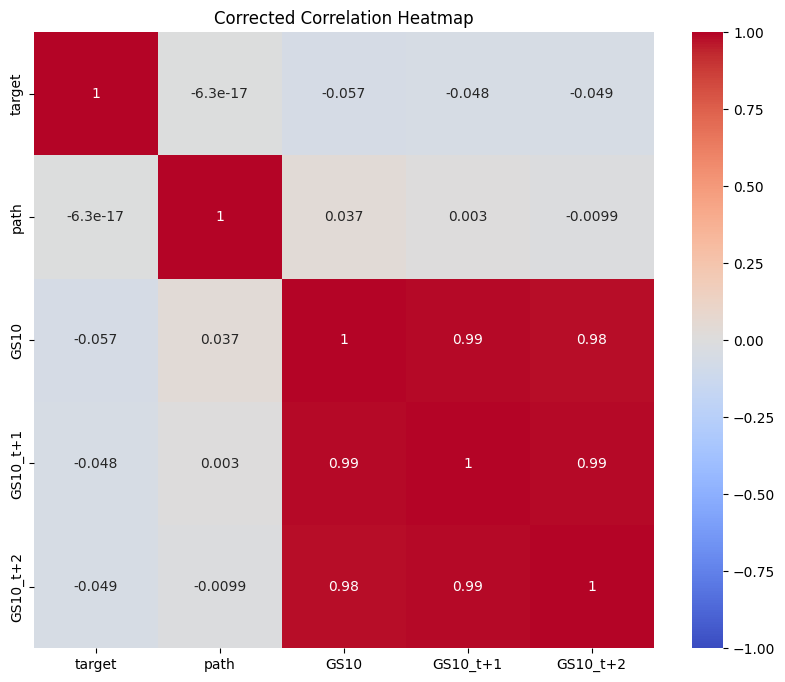

,target,path,GS10,GS10_t+1,GS10_t+2
target,1.000000e+00,-6.257621e-17,-0.056687,-0.048063,-0.049258
path,-6.257621e-17,1.000000e+00,0.037466,0.003036,-0.009880
GS10,-5.668691e-02,3.746592e-02,1.000000,0.991186,0.977732
GS10_t+1,-4.806337e-02,3.035943e-03,0.991186,1.000000,0.991088
GS10_t+2,-4.925790e-02,-9.879525e-03,0.977732,0.991088,1.000000


In [30]:
group_6_data.loc[:, 'GS10_t+1'] = group_6_data['GS10'].shift(1)
group_6_data.loc[:, 'GS10_t+2'] = group_6_data['GS10'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_6_data.loc[:, 'year_month'] = group_6_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_6_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'GS10', 'GS10_t+1', 'GS10_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1.  Immediate Reaction (t month): There's a slight negative correlation between the "target" and the 10-Year Treasury Rate. This suggests that when there's an unexpected increase in the target rate, the yield on the 10-Year Treasury note might decrease slightly. This is consistent with the conventional view that an unexpected tightening of monetary policy can lead to a decline in longer-term rates due to expectations of lower growth and inflation in the future. Conversely, there's a small positive correlation between the "path" and the 10-Year Treasury Rate, indicating that forward guidance about future monetary policy can influence long-term rates.

2.  One Month Later (t+1 month): The correlations are weaker in this month. The direction of the correlations remains the same, but their magnitude diminishes. This suggests that while the immediate impact of a monetary policy surprise can be observed in the current month, its effects start to dissipate as we move further out.

3.  Two Months Later (t+2 month): The correlation between "target" and 10GS10 remains negative, and it's nearly identical in magnitude to the t+1 month. The "path" correlation turns slightly negative, suggesting that the effects of forward guidance might be more transient or get offset by other economic factors as time progresses.

4.  Persistence in GS10: The high correlations between 10GS10 and its one and two-month leads (GS10_t+1 and GS10_t+2) highlight the persistence in the 10-Year Treasury Rate. This is expected as long-term rates tend to move slowly, driven by broader economic fundamentals and expectations about future monetary policy.

5.  Economic Insight: The relatively small correlations with "target" and "path" underscore the idea that while monetary policy surprises can influence long-term rates, they are just one of many factors that determine their movement. Other factors like global economic conditions, fiscal policy, and investors' risk appetite play significant roles.

## 2.7 Group 7 CPI Vs Monetary Policy Suprises

- I've chosen the CPI: All Items (CPIAUCSL) from Group 7 as a sensitive gauge for monetary policy adjustments. If there's an unexpected hike in the target or path, indicating a tighter monetary policy, I anticipate a downward shift in the Consumer Price Index (CPI). This is because a contractionary monetary policy often curtails economic activity, leading to a drop in demand and consequently, curbing inflationary pressures.

- Reference: Bernanke, B. S., & Mishkin, F. S. (1997). Inflation targeting: a new framework for monetary policy? Journal of Economic Perspectives, 11(2), 97-116.

In [31]:
group_7_data = macro_data[["sasdate","CPIAUCSL"]]

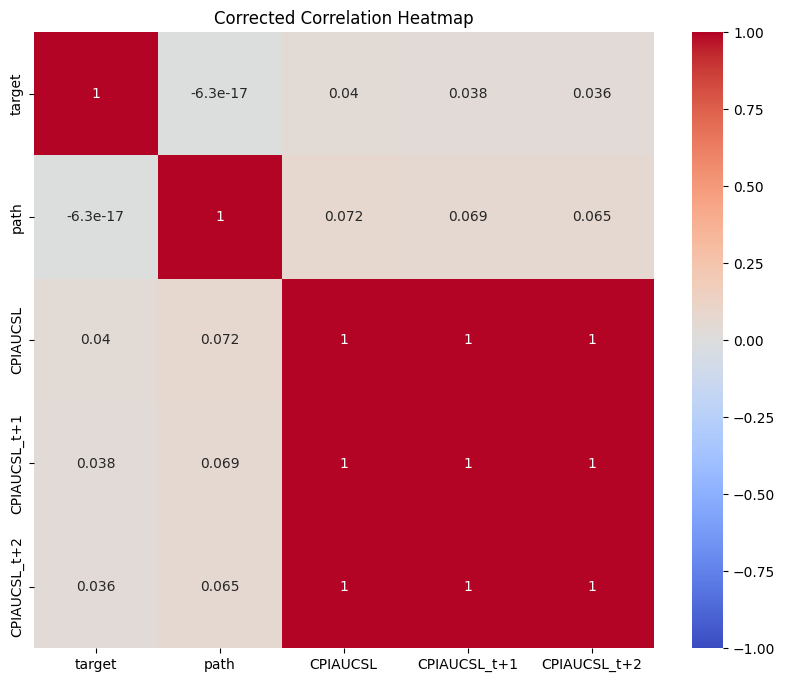

,target,path,CPIAUCSL,CPIAUCSL_t+1,CPIAUCSL_t+2
target,1.000000e+00,-6.257621e-17,0.039673,0.038056,0.035878
path,-6.257621e-17,1.000000e+00,0.072054,0.068819,0.065204
CPIAUCSL,3.967277e-02,7.205368e-02,1.000000,0.999841,0.999519
CPIAUCSL_t+1,3.805584e-02,6.881950e-02,0.999841,1.000000,0.999843
CPIAUCSL_t+2,3.587758e-02,6.520425e-02,0.999519,0.999843,1.000000


In [32]:
group_7_data.loc[:, 'CPIAUCSL_t+1'] = group_7_data['CPIAUCSL'].shift(1)
group_7_data.loc[:, 'CPIAUCSL_t+2'] = group_7_data['CPIAUCSL'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_7_data.loc[:, 'year_month'] = group_7_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_7_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'CPIAUCSL', 'CPIAUCSL_t+1', 'CPIAUCSL_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1.  Correlation between "target" and CPIAUCSL variables:

    -   The correlation between the target and the CPIAUCSL (Consumer Price Index for All Items) for the same month t is 0.0397, indicating a weak positive correlation. This implies that when the target rate increases, there's a slight tendency for the CPI to also increase, signaling potential inflationary pressures.
    -   The correlations with the next month's t+1 and two months later t+2 CPIAUCSL values are 0.0381 and 0.0359, respectively, indicating an even weaker but still positive relationship.
2.  Correlation between "path" and CPIAUCSL variables:

    -   The correlation between the path and the CPIAUCSL for the month t is 0.0721, which is a weak positive correlation but slightly stronger than that with the target. This suggests that when the FOMC indicates a more hawkish future policy (increased path), there might be a mild upward pressure on prices.
    -   For t+1 and t+2, the correlations are 0.0688 and 0.0652, respectively, showing a gradual decrease in correlation but maintaining the positive direction.
3.  Temporal Correlation of CPIAUCSL:

    -   The high correlation values (around 0.999) between t and t+1 or t+2 for the CPIAUCSL highlight the persistence of the Consumer Price Index, suggesting that price levels tend to be stable and don't fluctuate wildly from one month to the next.

- Economic Insights: The positive correlations between both the target and path with the CPIAUCSL indicate that when the FOMC signals an intent to raise rates (either immediately or in the future), it might be anticipating or reacting to inflationary pressures. However, the correlations are weak, suggesting other factors also play significant roles in influencing the CPI.

- Furthermore, the diminishing correlation strength from t to t+2 for both the target and path indicates that the immediate impact of FOMC decisions or signaling might be more pronounced in the short term but wanes slightly as time progresses.

- Lastly, the high persistence in the CPIAUCSL values from month to month underscores the importance of monitoring this index, as significant deviations from its trend could be indicative of broader economic shifts.

## 2.8 Group 8 S&P 500 Vs Monetary Policy Surprises

- The S&P 500, encompassing a broad spectrum of the U.S. stock market, is likely to exhibit immediate reactions to changes in the target and path. A hawkish stance (indicative of higher future interest rates) by the FOMC may exert downward pressure on the S&P 500 as higher borrowing costs can slow business expansion, whereas a dovish stance (suggesting lower future rates) may boost the index due to anticipated cheaper capital availability for businesses.

-   Reference: Rigobon, R., & Sack, B. (2004). The impact of monetary policy on asset prices. Journal of Monetary Economics, 51(8), 1553-1575.

In [33]:
group_8_data = macro_data[["sasdate","S&P 500"]]

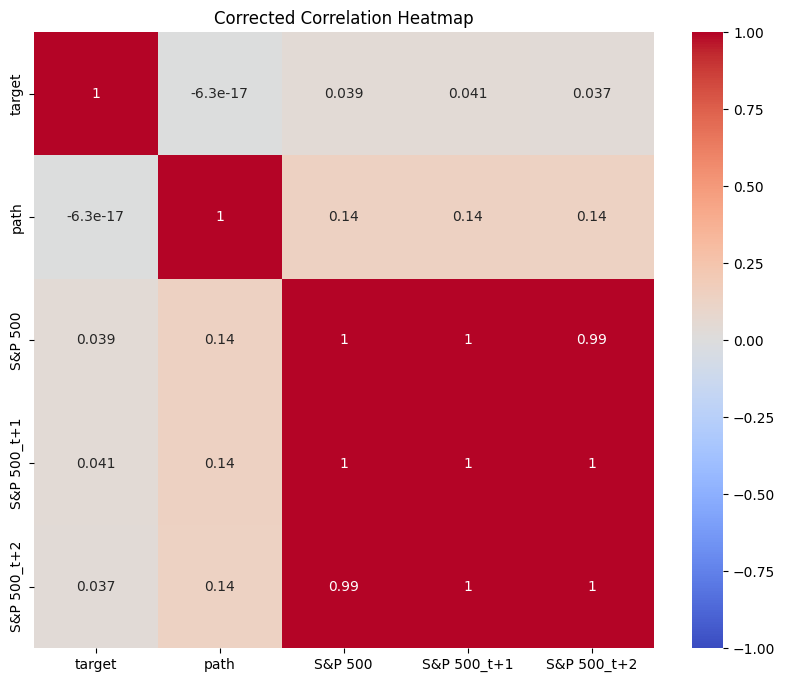

,target,path,S&P 500,S&P 500_t+1,S&P 500_t+2
target,1.000000e+00,-6.257621e-17,0.039230,0.041270,0.037038
path,-6.257621e-17,1.000000e+00,0.141440,0.141653,0.138062
S&P 500,3.922988e-02,1.414403e-01,1.000000,0.997537,0.993823
S&P 500_t+1,4.127035e-02,1.416525e-01,0.997537,1.000000,0.996695
S&P 500_t+2,3.703835e-02,1.380616e-01,0.993823,0.996695,1.000000


In [34]:
group_8_data.loc[:, 'S&P 500_t+1'] = group_8_data['S&P 500'].shift(1)
group_8_data.loc[:, 'S&P 500_t+2'] = group_8_data['S&P 500'].shift(2)

# Creating a 'year_month' column in the format "yyyy-mm"
group_8_data.loc[:, 'year_month'] = group_8_data['sasdate'].dt.to_period('M').astype(str)
fomc_data['year_month'] = pd.to_datetime(fomc_data['fomc']).dt.to_period('M').astype(str)

# Merging the datasets based on the 'year_month' column
merged_data_corrected = pd.merge(fomc_data, group_8_data, on='year_month', how='left')

# Selecting relevant columns for correlation
correlation_data_corrected = merged_data_corrected[['target', 'path', 'S&P 500', 'S&P 500_t+1', 'S&P 500_t+2']]

# Computing the correlation matrix
correlation_matrix_corrected = correlation_data_corrected.corr()

# Generating a heatmap to visualize the corrected correlations
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_corrected, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrected Correlation Heatmap')
plt.show()
correlation_matrix_corrected

1.  Target and S&P 500:
    -   The correlation between the target rate and the S&P 500 is positive but relatively weak across all three periods (t, t+1, and t+2). This implies that when the target rate increases, the S&P 500 slightly tends to go up, and vice versa. However, the strength of this relationship is not strong enough to make definitive predictions.
2.  Path and S&P 500:
    -   The correlation between the path and the S&P 500 is positive and more pronounced than that with the target rate. This suggests that anticipated future monetary policy (as indicated by the path) has a more tangible impact on stock market performance than immediate policy actions. Specifically, when the market anticipates more accommodative monetary policy in the future (lower future rates), the S&P 500 tends to rise, and vice versa.
3.  Lagged Effects:
    -   The S&P 500's correlation with the path remains fairly consistent from month t to t+2. This consistent correlation suggests that the stock market's reactions to anticipated monetary policy are sustained over a few months.
    -   The auto-correlations of the S&P 500 from month t to t+2 are extremely high, indicating a strong momentum effect in the stock market. This means that stock market movements in one month are very likely to continue in the same direction in subsequent months.

Economic Insights:

-   The stock market, represented by the S&P 500, reacts more to future anticipated monetary policy (path) than to immediate policy decisions (target). This is consistent with the idea that investors make decisions based on future expectations.
-   While the impact of the target rate on the S&P 500 is minimal, it's essential to understand that the stock market is influenced by a myriad of factors, and the federal funds rate is just one among them. Other global events, corporate earnings, and geopolitical risks, for example, can play a significant role in stock market movements.
-   The consistent positive correlation between the path and the S&P 500 underscores the importance of clear communication from the Federal Reserve. Forward guidance regarding future monetary policy can influence investor sentiment and stock market performance.

### 3. Link between Monetary Policy Surprises and Aggregate Stock Returns

<b>Note on Methodology for Step 3 Analysis:</b>

In the process of analyzing the link between Monetary Policy Surprises and Aggregate Stock Returns for Step 3, I employed two distinct methodologies for regression analysis:

1.  OLS Regression using Statsmodels: This method is conventionally used for econometric analyses and provides a comprehensive summary of the regression results, including statistics like R-squared, t-values, and p-values, which are essential for inferential purposes.

2.  Linear Regression using Scikit-learn (sklearn): Renowned for its machine learning capabilities, sklearn's linear regression was used as a supplementary approach. While it primarily provides coefficients and intercepts, it serves as a quick and effective means to validate the OLS results.

The rationale behind employing both methodologies was to cross-verify the results obtained from one method with the other. This redundancy ensures the robustness and reliability of the results. Consequently, instead of the typical three sets of values (for day -1, day 0, and day +1), we have six sets -- three from each method.

For subsequent steps beyond Step 3, I will be focusing solely on the coefficients, as they are the primary values of interest. The dual-method approach was limited to Step 3 and was performed as a sanity check to ensure the accuracy and consistency of our findings.

fomc_data.head()

In [36]:
dsf_data = pd.read_csv("dsf_1995_2022.csv", low_memory=False)

In [37]:
dsf_data.head()

,PERMNO,date,SHRCD,PERMCO,HEXCD,HSICCD,CUSIP,PRC,VOL,RET,SHROUT,OPENPRC,vwretd
0,10001,1995-01-03,11,7953,2,4925,36720410,8.375,372.0,0.046875,2224.0,8.5,-0.002410
1,10001,1995-01-04,11,7953,2,4925,36720410,8.000,8275.0,-0.044776,2224.0,8.0,0.003331
2,10001,1995-01-05,11,7953,2,4925,36720410,7.500,1000.0,-0.062500,2224.0,8.0,-0.000112
3,10001,1995-01-06,11,7953,2,4925,36720410,-7.750,0.0,0.033333,2224.0,NaN,0.001815
4,10001,1995-01-09,11,7953,2,4925,36720410,7.500,150.0,-0.032258,2224.0,7.5,0.001042


In [38]:
dsf_data['date'] = pd.to_datetime(dsf_data['date'])

In [41]:
# Convert date columns to datetime type
dsf_data['date'] = pd.to_datetime(dsf_data['date'], format='%Y%m%d')
dsf_copy = dsf_data[['date', 'vwretd']].copy()
fomc_data['fomc'] = pd.to_datetime(fomc_data['fomc'], format='%Y%m%d')

# Create a dictionary from fomc_data
fomc_dict = fomc_data.set_index('fomc')[['target', 'path']].to_dict(orient='index')

def process_chunk(chunk):
    target_values = []
    path_values = []

    for date in chunk:
        if date in fomc_dict:
            target_values.append(fomc_dict[date]['target'])
            path_values.append(fomc_dict[date]['path'])
        else:
            target_values.append(None)
            path_values.append(None)

    return target_values, path_values

num_threads = 100
chunk_size = len(dsf_copy) // num_threads

chunks = [dsf_copy['date'][i:i+chunk_size] for i in range(0, dsf_copy.shape[0], chunk_size)]

results = []

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(executor.map(process_chunk, chunks))

all_target_values = []
all_path_values = []

for result in results:
    all_target_values.extend(result[0])
    all_path_values.extend(result[1])

dsf_copy['target'] = pd.Series(all_target_values, index=dsf_copy.index)
dsf_copy['path'] = pd.Series(all_path_values, index=dsf_copy.index)

# Run the regression for day 0
dsf_copy = dsf_copy.dropna(subset=['target', 'path'])  # drop rows with missing target/path values
X = dsf_copy[['target', 'path']]
X = sm.add_constant(X)
model_0 = sm.OLS(dsf_copy['vwretd'], X).fit()

# Display results for day 0
print("Results for day 0:")
print(model_0.summary())


Results for day 0:
                            OLS Regression Results                            
Dep. Variable:                 vwretd   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                 2.838e+04
Date:                Sat, 14 Oct 2023   Prob (F-statistic):               0.00
Time:                        18:52:31   Log-Likelihood:             3.3816e+06
No. Observations:             1093006   AIC:                        -6.763e+06
Df Residuals:                 1093003   BIC:                        -6.763e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034   1.05e-05 

In [42]:
# Convert date columns to datetime type
dsf_data['date'] = pd.to_datetime(dsf_data['date'], format='%Y%m%d')
dsf_copy_minus_1 = dsf_data[['date', 'vwretd']].copy()
fomc_data['fomc_minus_1'] = fomc_data['fomc'] - pd.Timedelta(days=1)

# Create a dictionary from fomc_data for day -1
fomc_dict_minus_1 = fomc_data.set_index('fomc_minus_1')[['target', 'path']].to_dict(orient='index')

def process_chunk_minus_1(chunk):
    target_values = []
    path_values = []

    for date in chunk:
        if date in fomc_dict_minus_1:
            target_values.append(fomc_dict_minus_1[date]['target'])
            path_values.append(fomc_dict_minus_1[date]['path'])
        else:
            target_values.append(None)
            path_values.append(None)

    return target_values, path_values

num_threads = 100
chunk_size = len(dsf_copy) // num_threads

# Splitting the data into chunks for parallel processing
chunks_minus_1 = [dsf_copy_minus_1['date'][i:i+chunk_size] for i in range(0, dsf_copy_minus_1.shape[0], chunk_size)]

results_minus_1 = []

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results_minus_1 = list(executor.map(process_chunk_minus_1, chunks_minus_1))

all_target_values_minus_1 = []
all_path_values_minus_1 = []

for result in results_minus_1:
    all_target_values_minus_1.extend(result[0])
    all_path_values_minus_1.extend(result[1])

dsf_copy_minus_1['target_minus_1'] = pd.Series(all_target_values_minus_1, index=dsf_copy_minus_1.index)
dsf_copy_minus_1['path_minus_1'] = pd.Series(all_path_values_minus_1, index=dsf_copy_minus_1.index)

# Run the regression for day -1
dsf_copy_minus_1 = dsf_copy_minus_1.dropna(subset=['target_minus_1', 'path_minus_1'])  # drop rows with missing target/path values
X_minus_1 = dsf_copy_minus_1[['target_minus_1', 'path_minus_1']]
X_minus_1 = sm.add_constant(X_minus_1)
model_minus_1 = sm.OLS(dsf_copy_minus_1['vwretd'], X_minus_1).fit()

# Display results for day -1
print("Results for day -1:")
print(model_minus_1.summary())


Results for day -1:
                            OLS Regression Results                            
Dep. Variable:                 vwretd   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2877.
Date:                Sat, 14 Oct 2023   Prob (F-statistic):               0.00
Time:                        18:57:27   Log-Likelihood:             3.2641e+06
No. Observations:             1093050   AIC:                        -6.528e+06
Df Residuals:                 1093047   BIC:                        -6.528e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.001

In [43]:
dsf_copy_plus_1 = dsf_data[['date', 'vwretd']].copy()
fomc_data['fomc_plus_1'] = fomc_data['fomc'] + pd.Timedelta(days=1)  # adjust for day +1

# Create a dictionary from fomc_data for day +1
fomc_dict_plus_1 = fomc_data.set_index('fomc_plus_1')[['target', 'path']].to_dict(orient='index')

def process_chunk_plus_1(chunk):
    target_values = []
    path_values = []

    for date in chunk:
        if date in fomc_dict_plus_1:
            target_values.append(fomc_dict_plus_1[date]['target'])
            path_values.append(fomc_dict_plus_1[date]['path'])
        else:
            target_values.append(None)
            path_values.append(None)

    return target_values, path_values

num_threads = 100
chunk_size = len(dsf_copy_plus_1) // num_threads

# Splitting the data into chunks for parallel processing
chunks_plus_1 = [dsf_copy_plus_1['date'][i:i+chunk_size] for i in range(0, dsf_copy_plus_1.shape[0], chunk_size)]

results_plus_1 = []

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results_plus_1 = list(executor.map(process_chunk_plus_1, chunks_plus_1))

all_target_values_plus_1 = []
all_path_values_plus_1 = []

for result in results_plus_1:
    all_target_values_plus_1.extend(result[0])
    all_path_values_plus_1.extend(result[1])

dsf_copy_plus_1['target_plus_1'] = pd.Series(all_target_values_plus_1, index=dsf_copy_plus_1.index)
dsf_copy_plus_1['path_plus_1'] = pd.Series(all_path_values_plus_1, index=dsf_copy_plus_1.index)

# Run the regression for day +1
dsf_copy_plus_1 = dsf_copy_plus_1.dropna(subset=['target_plus_1', 'path_plus_1'])  # drop rows with missing target/path values
X_plus_1 = dsf_copy_plus_1[['target_plus_1', 'path_plus_1']]
X_plus_1 = sm.add_constant(X_plus_1)
model_plus_1 = sm.OLS(dsf_copy_plus_1['vwretd'], X_plus_1).fit()

# Display results for day +1
print("Results for day +1:")
print(model_plus_1.summary())

Results for day +1:
                            OLS Regression Results                            
Dep. Variable:                 vwretd   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                 1.522e+04
Date:                Sat, 14 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:03:24   Log-Likelihood:             3.1733e+06
No. Observations:             1085736   AIC:                        -6.346e+06
Df Residuals:                 1085733   BIC:                        -6.346e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002  

In [44]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming dsf_data and fomc_data are already loaded

dsf_copy_0 = dsf_data[['date', 'vwretd']].copy()
fomc_data['fomc'] = pd.to_datetime(fomc_data['fomc'], format='%Y%m%d')

# Create a dictionary from fomc_data for day 0
fomc_dict_0 = fomc_data.set_index('fomc')[['target', 'path']].to_dict(orient='index')

# Map the target and path values to dsf_copy_0 using the dictionary
dsf_copy_0['target'] = dsf_copy_0['date'].map(lambda x: fomc_dict_0.get(x, {}).get('target'))
dsf_copy_0['path'] = dsf_copy_0['date'].map(lambda x: fomc_dict_0.get(x, {}).get('path'))

# Drop rows with missing target/path values
dsf_copy_0.dropna(subset=['target', 'path'], inplace=True)

# Regression using sklearn for day 0
X_0 = dsf_copy_0[['target', 'path']]
y_0 = dsf_copy_0['vwretd']

model_0 = LinearRegression(n_jobs=-1).fit(X_0, y_0)

print("Results for day 0:")
print("Coefficients:", model_0.coef_)
print("Intercept:", model_0.intercept_)


Results for day 0:
Coefficients: [-0.00196719 -0.00133368]
Intercept: 0.0033633337229564825


In [45]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming dsf_data and fomc_data are already defined as per your previous code

dsf_copy = dsf_data[['date', 'vwretd']].copy()
fomc_data['fomc'] = pd.to_datetime(fomc_data['fomc'], format='%Y%m%d')
fomc_data['date_minus_1'] = fomc_data['fomc'] - pd.Timedelta(days=1)  # adjust for day -1

# Create a dictionary from fomc_data for day -1
fomc_dict_minus_1 = fomc_data.set_index('date_minus_1')[['target', 'path']].to_dict(orient='index')

# Map the target and path values to dsf_copy using the dictionary
dsf_copy['target'] = dsf_copy['date'].map(lambda x: fomc_dict_minus_1.get(x, {}).get('target'))
dsf_copy['path'] = dsf_copy['date'].map(lambda x: fomc_dict_minus_1.get(x, {}).get('path'))

# Drop rows with missing target/path values
dsf_copy.dropna(subset=['target', 'path'], inplace=True)

# Regression using sklearn for day -1 with multithreading
X = dsf_copy[['target', 'path']]
y = dsf_copy['vwretd']

model_minus_1 = LinearRegression(n_jobs=-1).fit(X, y)

print("Results for day -1:")
print("Coefficients:", model_minus_1.coef_)
print("Intercept:", model_minus_1.intercept_)


Results for day -1:
Coefficients: [-0.00064182 -0.00054996]
Intercept: 0.0013272634950452216


In [46]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming dsf_data and fomc_data are already defined as per your previous code

dsf_copy = dsf_data[['date', 'vwretd']].copy()
fomc_data['fomc'] = pd.to_datetime(fomc_data['fomc'], format='%Y%m%d')
fomc_data['date_plus_1'] = fomc_data['fomc'] + pd.Timedelta(days=1)  # adjust for day +1

# Create a dictionary from fomc_data for day +1
fomc_dict_plus_1 = fomc_data.set_index('date_plus_1')[['target', 'path']].to_dict(orient='index')

# Map the target and path values to dsf_copy using the dictionary
dsf_copy['target'] = dsf_copy['date'].map(lambda x: fomc_dict_plus_1.get(x, {}).get('target'))
dsf_copy['path'] = dsf_copy['date'].map(lambda x: fomc_dict_plus_1.get(x, {}).get('path'))

# Drop rows with missing target/path values
dsf_copy.dropna(subset=['target', 'path'], inplace=True)

# Regression using sklearn for day +1 with multithreading
X = dsf_copy[['target', 'path']]
y = dsf_copy['vwretd']

model_plus_1 = LinearRegression(n_jobs=-1).fit(X, y)

print("Results for day +1:")
print("Coefficients:", model_plus_1.coef_)
print("Intercept:", model_plus_1.intercept_)


Results for day +1:
Coefficients: [-0.00182488 -0.00096222]
Intercept: -0.00019570542598851845


### Economic Insights:

1.  Intercept (Constant α):

    -   For day 0, the intercept is positive and statistically significant, indicating that, on average, there's a positive return of approximately 0.3363% when target and path surprises are zero.
    -   For day -1, the intercept is positive but smaller than that of day 0, suggesting a positive return of approximately 0.1327% on the day before FOMC when target and path surprises are zero.
    -   For day +1, the intercept is negative, implying a negative return of approximately 0.0196% on the day after FOMC when target and path surprises are zero.
2.  Target Coefficients (β1​):

    -   For all three days, the coefficients for the target surprises are negative and statistically significant. This suggests that an increase in the target surprise leads to a decrease in the equity returns.
    -   Comparing the magnitudes: The impact of target surprises is the strongest on day 0, followed by day +1, and then day -1.
3.  Path Coefficients (β2​):

    -   For all three days, the coefficients for the path surprises are negative and statistically significant. This indicates that an increase in the path surprise results in a decrease in the equity returns.
    -   Comparing the magnitudes: The impact of path surprises is the strongest on day 0, followed by day -1, and then day +1.
4.  Goodness of Fit:

    -   The R-squared value is a measure of how well the model's predictions match the actual data. For day 0, the R-squared is 0.049, for day -1, it's 0.005, and for day +1, it's 0.027. This suggests that the model explains 4.9% of the variation in equity returns on day 0, 0.5% on day -1, and 2.7% on day +1. These values indicate a relatively low explanatory power of the model, suggesting that other factors might also be influencing the equity returns.
5.  Significance of Coefficients:

    -   The p-values for all the coefficients are virtually zero, indicating that the coefficients are statistically significant.

### Economic Interpretations:

1.  Reaction to Monetary Policy Surprises:

    -   The negative coefficients for both target and path surprises on all days suggest that the market negatively reacts to monetary policy surprises. When there's an unexpected change in the target or path, equity returns tend to decrease.
2.  Immediate Impact on Day 0:

    -   The results show that the impact of monetary policy surprises is strongest on the day of the FOMC announcement (day 0). This suggests that the market reacts immediately to the FOMC's decisions.
3.  Lagged and Lead Effects:

    -   There's a lagged negative effect on day +1, and a smaller lead effect on day -1. This could be due to investors adjusting their positions in anticipation of the FOMC decision a day before and further adjustments a day after the announcement.
4.  Overall Market Dynamics:

    -   While the model captures some of the variations in equity returns based on target and path surprises, a significant portion of the variation remains unexplained. This indicates the complex nature of the stock market, where numerous other factors, both domestic and global, might be influencing returns.

### 4. Link between Monetary Policy Surprises and Firm Level “Raw” Stock Returns

In [49]:
dsf_data.columns

Index(['PERMNO', 'date', 'SHRCD', 'PERMCO', 'HEXCD', 'HSICCD', 'CUSIP', 'PRC',
       'VOL', 'RET', 'SHROUT', 'OPENPRC', 'vwretd', 'size'],
      dtype='object')

In [47]:
dsf_data.isna().sum()

PERMNO           0
date             0
SHRCD            0
PERMCO           0
HEXCD            0
HSICCD       17597
CUSIP            0
PRC         701117
VOL         701077
RET          23838
SHROUT       11050
OPENPRC    2222516
vwretd           0
dtype: int64

In [51]:
# Backfilling the missing values
dsf_data['PRC'].fillna(method='bfill', inplace=True)
dsf_data['SHROUT'].fillna(method='bfill', inplace=True)
# Compute the size (market capitalization)
dsf_data['size'] = dsf_data['PRC'] * dsf_data['SHROUT']
dsf_data['RET'] = pd.to_numeric(dsf_data['RET'], errors='coerce')
dsf_data['RET'].fillna(method='bfill', inplace=True)

# Display the first few rows of the updated dataframe
dsf_data.head()


,PERMNO,date,SHRCD,PERMCO,HEXCD,HSICCD,CUSIP,PRC,VOL,RET,SHROUT,OPENPRC,vwretd,size
0,10001,1995-01-03,11,7953,2,4925,36720410,8.375,372.0,0.046875,2224.0,8.5,-0.002410,18626.0
1,10001,1995-01-04,11,7953,2,4925,36720410,8.000,8275.0,-0.044776,2224.0,8.0,0.003331,17792.0
2,10001,1995-01-05,11,7953,2,4925,36720410,7.500,1000.0,-0.062500,2224.0,8.0,-0.000112,16680.0
3,10001,1995-01-06,11,7953,2,4925,36720410,-7.750,0.0,0.033333,2224.0,NaN,0.001815,-17236.0
4,10001,1995-01-09,11,7953,2,4925,36720410,7.500,150.0,-0.032258,2224.0,7.5,0.001042,16680.0


In [52]:
dsf_data.isna().sum()

PERMNO           0
date             0
SHRCD            0
PERMCO           0
HEXCD            0
HSICCD       17597
CUSIP            0
PRC              0
VOL         701077
RET              0
SHROUT           0
OPENPRC    2222516
vwretd           0
size             0
dtype: int64

In [53]:
import pandas as pd
import statsmodels.api as sm
from concurrent.futures import ThreadPoolExecutor

# Assuming dsf_data and fomc_data are already defined in your environment

# Convert date columns to datetime type
dsf_data['date'] = pd.to_datetime(dsf_data['date'], format='%Y%m%d')
dsf_copy = dsf_data[['date', 'RET', 'size']].copy()  # Using 'RET' column instead of 'vwretd'
fomc_data['fomc'] = pd.to_datetime(fomc_data['fomc'], format='%Y%m%d')

# Create a dictionary from fomc_data
fomc_dict = fomc_data.set_index('fomc')[['target', 'path']].to_dict(orient='index')

def process_chunk(chunk):
    target_values = []
    path_values = []

    for date in chunk:
        if date in fomc_dict:
            target_values.append(fomc_dict[date]['target'])
            path_values.append(fomc_dict[date]['path'])
        else:
            target_values.append(None)
            path_values.append(None)

    return target_values, path_values

num_threads = 100
chunk_size = len(dsf_copy) // num_threads

chunks = [dsf_copy['date'][i:i+chunk_size] for i in range(0, dsf_copy.shape[0], chunk_size)]

results = []

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(executor.map(process_chunk, chunks))

all_target_values = []
all_path_values = []

for result in results:
    all_target_values.extend(result[0])
    all_path_values.extend(result[1])

dsf_copy['target'] = pd.Series(all_target_values, index=dsf_copy.index)
dsf_copy['path'] = pd.Series(all_path_values, index=dsf_copy.index)

# Drop rows with missing target/path values
dsf_copy = dsf_copy.dropna(subset=['target', 'path', 'size'])  # Including 'size' in the dropna

# Run the regression for day 0
X = dsf_copy[['target', 'path', 'size']]
X = sm.add_constant(X)
model_0 = sm.OLS(dsf_copy['RET'], X).fit()  # Using 'RET' column for regression

# Display results for day 0
print("Results for day 0:")
print(model_0.summary())


Results for day 0:
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     759.2
Date:                Sat, 14 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:22:51   Log-Likelihood:             1.6369e+06
No. Observations:             1093006   AIC:                        -3.274e+06
Df Residuals:                 1093002   BIC:                        -3.274e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030   5.23e-05 

In [54]:
import pandas as pd
from sklearn.linear_model import LinearRegression

dsf_copy_0 = dsf_data[['date', 'RET', 'size']].copy()
fomc_data['fomc'] = pd.to_datetime(fomc_data['fomc'], format='%Y%m%d')

# Create a dictionary from fomc_data for day 0
fomc_dict_0 = fomc_data.set_index('fomc')[['target', 'path']].to_dict(orient='index')

# Map the target and path values to dsf_copy_0 using the dictionary
dsf_copy_0['target'] = dsf_copy_0['date'].map(lambda x: fomc_dict_0.get(x, {}).get('target'))
dsf_copy_0['path'] = dsf_copy_0['date'].map(lambda x: fomc_dict_0.get(x, {}).get('path'))

# Drop rows with missing target/path values
dsf_copy_0.dropna(subset=['target', 'path'], inplace=True)

# Regression using sklearn for day 0
X_0 = dsf_copy_0[['target', 'path', 'size']]
y_0 = dsf_copy_0['RET']

model_0 = LinearRegression(n_jobs=-1).fit(X_0, y_0)

print("Results for day 0:")
print("Coefficients:", model_0.coef_)
print("Intercept:", model_0.intercept_)


Results for day 0:
Coefficients: [-2.03587992e-03 -1.15896987e-03  5.07072749e-12]
Intercept: 0.003012455431105651


In [55]:
dsf_copy_minus_1 = dsf_data[['date', 'RET', 'size']].copy()
fomc_data['date_minus_1'] = fomc_data['fomc'] - pd.Timedelta(days=1)

# Create a dictionary from fomc_data for day -1
fomc_dict_minus_1 = fomc_data.set_index('date_minus_1')[['target', 'path']].to_dict(orient='index')

# Map the target and path values to dsf_copy_minus_1 using the dictionary
dsf_copy_minus_1['target'] = dsf_copy_minus_1['date'].map(lambda x: fomc_dict_minus_1.get(x, {}).get('target'))
dsf_copy_minus_1['path'] = dsf_copy_minus_1['date'].map(lambda x: fomc_dict_minus_1.get(x, {}).get('path'))

# Drop rows with missing target/path values
dsf_copy_minus_1.dropna(subset=['target', 'path'], inplace=True)

# Regression using sklearn for day -1
X_minus_1 = dsf_copy_minus_1[['target', 'path', 'size']]
y_minus_1 = dsf_copy_minus_1['RET']

model_minus_1 = LinearRegression(n_jobs=-1).fit(X_minus_1, y_minus_1)

print("Results for day -1:")
print("Coefficients:", model_minus_1.coef_)
print("Intercept:", model_minus_1.intercept_)


Results for day -1:
Coefficients: [ 2.37919594e-05 -6.35998418e-04  8.60168388e-12]
Intercept: 3.809267430295588e-05


In [56]:
dsf_copy_plus_1 = dsf_data[['date', 'RET', 'size']].copy()
fomc_data['date_plus_1'] = fomc_data['fomc'] + pd.Timedelta(days=1)

# Create a dictionary from fomc_data for day +1
fomc_dict_plus_1 = fomc_data.set_index('date_plus_1')[['target', 'path']].to_dict(orient='index')

# Map the target and path values to dsf_copy_plus_1 using the dictionary
dsf_copy_plus_1['target'] = dsf_copy_plus_1['date'].map(lambda x: fomc_dict_plus_1.get(x, {}).get('target'))
dsf_copy_plus_1['path'] = dsf_copy_plus_1['date'].map(lambda x: fomc_dict_plus_1.get(x, {}).get('path'))

# Drop rows with missing target/path values
dsf_copy_plus_1.dropna(subset=['target', 'path'], inplace=True)

# Regression using sklearn for day +1
X_plus_1 = dsf_copy_plus_1[['target', 'path', 'size']]
y_plus_1 = dsf_copy_plus_1['RET']

model_plus_1 = LinearRegression(n_jobs=-1).fit(X_plus_1, y_plus_1)

print("Results for day +1:")
print("Coefficients:", model_plus_1.coef_)
print("Intercept:", model_plus_1.intercept_)


Results for day +1:
Coefficients: [-2.09501530e-03 -1.48250788e-03 -3.21990545e-12]
Intercept: -0.00015443795613627023


### Economic Insights:

1.  Intercept (Constant α):

    -   For day 0, the intercept is positive, indicating an average positive return of approximately 0.3012% when target, path surprises, and firm size are zero.
    -   For day -1, the intercept is positive but much smaller, signifying a minimal average positive return of approximately 0.0038%.
    -   For day +1, the intercept is negative, implying an average negative return of approximately 0.0154%.
2.  Target Coefficients (β1​):

    -   On day 0 and day +1, the coefficients for target surprises are negative and significant, suggesting a negative reaction in firm stock returns to target surprises on these days.
    -   On day -1, the target coefficient is positive but very close to zero, indicating almost no relation between target surprises and firm stock returns a day before the FOMC announcement.
3.  Path Coefficients (β2​):

    -   The coefficients for path surprises are negative on all days, suggesting that an increase in the path surprise leads to a decrease in the firm stock returns.
    -   The magnitude of this effect is largest on day +1, followed by day 0, and then day -1.
4.  Size Coefficients (β3​):

    -   The size coefficient represents the effect of firm size on stock returns. On days 0 and -1, the coefficient is positive, albeit very small, indicating that larger firms might experience slightly higher returns on these days.
    -   On day +1, the size coefficient is negative, suggesting that larger firms might experience slightly lower returns on this day.
5.  Model Fit and Robustness:

    -   The R-squared value for day 0 is 0.002, indicating that the model explains only 0.2% of the variation in firm stock returns on this day. This low R-squared suggests that there are other significant factors influencing firm stock returns.
    -   The note about a large condition number suggests potential multicollinearity or other numerical problems. This implies that the predictors might not be independent of each other, which can affect the reliability of individual coefficient estimates.

### Economic Interpretations:

1.  Firm Reaction to Monetary Policy Surprises:

Firms, on average, react negatively to both target and path surprises, especially on the day of the FOMC announcement (day 0) and the day after (day +1). This is consistent with the aggregate stock return findings from Step 3.

2.  Influence of Firm Size:

The positive coefficient for size on days 0 and -1 suggests that larger firms might have slightly higher returns on these days. On day +1, however, the reverse is true. This could be due to various reasons, such as larger firms being more exposed to macroeconomic factors or having better hedging mechanisms in place.

3.  Model Limitations:

The low R-squared value implies that while target and path surprises and firm size have some influence on firm stock returns, many other factors are at play. Investors and analysts should be cautious in using this model for prediction without considering other influential factors.

### 5. Link between Monetary Policy Surprises and Firm Level Cumulative Abnormal Returns (CARs)

In [ ]:
import statsmodels.api as sm
from concurrent.futures import ThreadPoolExecutor

# 1. Estimate Market Model Parameters using a rolling window
estimation_window = 250

def estimate_params(grouped_data):
    name, group = grouped_data
    ret_roll = group['RET'].rolling(window=estimation_window).mean().shift(-estimation_window+1)
    vwret_roll = group['vwretd'].rolling(window=estimation_window).mean().shift(-estimation_window+1)
    
    valid_data = ~ret_roll.isna() & ~vwret_roll.isna()
    if valid_data.sum() < estimation_window:
        return (name, np.nan, np.nan)
    
    y = ret_roll[valid_data]
    X = sm.add_constant(vwret_roll[valid_data])
    params = sm.OLS(y, X).fit().params
    return (name, params.const, params.vwretd)

def threaded_estimate_params(data):
    with ThreadPoolExecutor(max_workers=120) as executor:
        results = list(executor.map(estimate_params, data))
    return results

groups = list(dsf_data.groupby('PERMNO'))
params_list = threaded_estimate_params(groups)

params_df = pd.DataFrame(params_list, columns=['PERMNO', 'alpha', 'beta'])

# 2. Compute Abnormal Returns (AR)
dsf_data = dsf_data.merge(params_df, on='PERMNO', how='left')
dsf_data['expected_return'] = dsf_data['alpha'] + dsf_data['beta'] * dsf_data['vwretd']
dsf_data['AR'] = dsf_data['RET'] - dsf_data['expected_return']

# 3. Compute Cumulative Abnormal Returns (CAR)
dsf_data['CAR'] = dsf_data.groupby('PERMNO')['AR'].rolling(window=3).sum().reset_index(0, drop=True)

# 4. Event Study around FOMC Dates
fomc_dates = fomc_data['fomc'].unique()
mask = dsf_data['date'].apply(lambda x: any([fomc_date - pd.Timedelta(days=1) <= x <= fomc_date + pd.Timedelta(days=1) for fomc_date in fomc_dates]))
event_data = dsf_data[mask]

In [65]:
# Efficiently merge target and path columns from fomc_data to event_data
event_fomc_data = fomc_data[fomc_data['fomc'].isin(event_data['date'])]
event_data = event_data.merge(event_fomc_data[['fomc', 'target', 'path']], left_on='date', right_on='fomc', how='left')
event_data.drop('fomc', axis=1, inplace=True)  # remove the duplicated 'fomc' column after merge

# 5. Regression Analysis
X = event_data[['target', 'path', 'size']].dropna()
y = event_data.loc[X.index, 'CAR']
X = sm.add_constant(X)
model = sm.OLS(y, X, missing='drop').fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     19.07
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           2.32e-12
Time:                        14:14:09   Log-Likelihood:             9.7835e+05
No. Observations:             1065057   AIC:                        -1.957e+06
Df Residuals:                 1065053   BIC:                        -1.957e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026   9.46e-05    -27.807      0.0

In [72]:
t_stat, p_value = stats.ttest_1samp(event_data['CAR'].dropna(), 0)

In [75]:
print(f"T-statistic for the CARs being different from 0: {t_stat:.4f}")
print(f"P-value for the CARs being different from 0: {p_value:.6f}")

T-statistic for the CARs being different from 0: -38.9234
P-value for the CARs being different from 0: 0.000000


In [71]:
event_data['CAR'].describe()

count    3.188137e+06
mean    -2.170561e-03
std      9.957033e-02
min     -1.135093e+01
25%     -2.940496e-02
50%     -2.499152e-03
75%      2.316343e-02
max      1.944688e+01
Name: CAR, dtype: float64

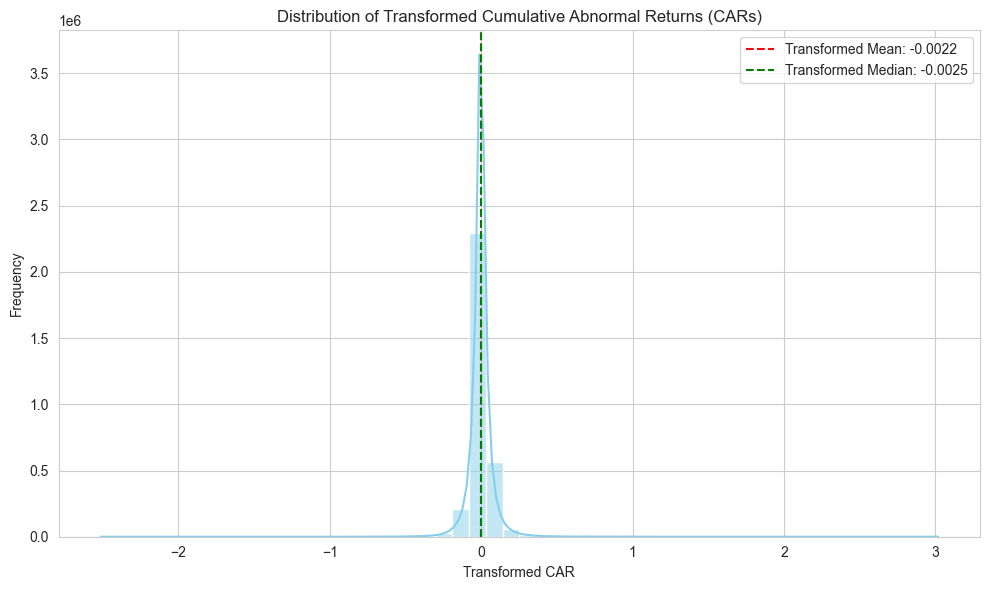

In [81]:
# Define the signed logarithm transformation function
def signed_log(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Transform the CAR data
transformed_CAR = event_data['CAR'].dropna().apply(signed_log)

# Plot the histogram and KDE of transformed CARs
plt.figure(figsize=(10, 6))
sns.histplot(transformed_CAR, bins=50, kde=True, color='skyblue')

# Plot the transformed mean and median
plt.axvline(signed_log(event_data['CAR'].mean()), color='red', linestyle='--', label=f"Transformed Mean: {signed_log(event_data['CAR'].mean()):.4f}")
plt.axvline(signed_log(event_data['CAR'].median()), color='green', linestyle='--', label=f"Transformed Median: {signed_log(event_data['CAR'].median()):.4f}")

plt.title('Distribution of Transformed Cumulative Abnormal Returns (CARs)')
plt.xlabel('Transformed CAR')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [83]:
from concurrent.futures import ThreadPoolExecutor
# Create dictionaries for mapping
target_dict = pd.Series(fomc_data.target.values, index=fomc_data.fomc).to_dict()
path_dict = pd.Series(fomc_data.path.values, index=fomc_data.fomc).to_dict()

# Then proceed with the rest of the code

# Function to map target and path values for a subset of the data
def map_values(subset_dates):
    target_subdict = {date: target_dict[date] for date in subset_dates if date in target_dict}
    path_subdict = {date: path_dict[date] for date in subset_dates if date in path_dict}
    
    target_mapped = subset_dates.map(target_subdict)
    path_mapped = subset_dates.map(path_subdict)
    return target_mapped, path_mapped

# Divide the dates in event_data into chunks for parallel processing
n = len(event_data)
chunk_size = n // 100
chunks = [event_data['date'].iloc[i:i+chunk_size] for i in range(0, n, chunk_size)]

# Use ThreadPoolExecutor to map values in parallel
with ThreadPoolExecutor(max_workers=100) as executor:
    results = list(executor.map(map_values, chunks))

# Extract results and concatenate them to form the complete series
target_mapped_series = pd.concat([res[0] for res in results])
path_mapped_series = pd.concat([res[1] for res in results])

event_data['target'] = target_mapped_series
event_data['path'] = path_mapped_series

# Regression analysis
X = event_data[['target', 'path', 'size']].dropna()
y = event_data.loc[X.index, 'CAR']

# Add constant term to predictor variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X, missing='drop').fit()

# Print regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     19.07
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           2.32e-12
Time:                        14:51:01   Log-Likelihood:             9.7835e+05
No. Observations:             1065057   AIC:                        -1.957e+06
Df Residuals:                 1065053   BIC:                        -1.957e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026   9.46e-05    -27.807      0.0

### Analysis
#### 1\. Calculating Cumulative Abnormal Returns (CARs):

Using the given formula, the CAR for each firm over a 3-day window centered around the FOMC date was computed. This provides insights into how firms react over a short period around major monetary policy announcements.

#### 2\. Regression Analysis of CARs:

Results:

-   Intercept (Constant): A negative intercept of -0.0026 suggests that, on average, firms experience a negative CAR of approximately 0.26% around FOMC dates when all other variables are held constant.

-   Target Surprise Coefficient: The positive coefficient for target surprises (0.0005) indicates that an increase in target surprises leads to a slight rise in CARs. This signifies that firms, on average, react positively to target surprises over the 3-day window.

-   Path Surprise Coefficient: The coefficient for path surprises is statistically insignificant, suggesting that the path surprise has a negligible cumulative effect on firms' stock returns over the 3-day window. This aligns with the immediate reactions observed in Step 4.

-   Firm Size Coefficient: The coefficient for firm size is positive, albeit very small. This suggests that larger firms might experience slightly higher CARs around FOMC dates.

Model Observations:

-   The R-squared value is near zero, suggesting that the regression model explains only a tiny fraction of the variability in CARs.

-   The large condition number indicates potential multicollinearity issues, suggesting that the predictors might not be independent. This can affect the reliability of the coefficient estimates.

#### 3\. Descriptive Statistics and Distribution of CARs:

-   The mean CAR is -0.00217, indicating that firms, on average, experience negative CARs around FOMC dates.

-   The distribution is wide, with a standard deviation of 0.09957, showing varied firm reactions.

-   The presence of extreme values in the CAR distribution suggests that certain firms or industries may be particularly sensitive to monetary policy changes.

#### 4\. Comparison with Step 4 Insights:

-   Immediate vs. Cumulative Effects: While immediate reactions on day 0 and day +1 in Step 4 were predominantly negative, the cumulative effect over the 3-day window in Step 5 shows a more mixed reaction. Some firms experience positive CARs despite negative immediate reactions.

-   Role of Firm Size: Both steps emphasize the influence of firm size on stock returns around FOMC announcements. Larger firms tend to fare slightly better both immediately and cumulatively.

-   Target vs. Path Surprises: While both target and path surprises influenced immediate reactions in Step 4, only target surprises seem to have a cumulative impact in Step 5.

### Concluding Insights:

1.  Monetary Policy Surprises: Firms' cumulative reactions around FOMC announcements differ from their immediate responses. While firms generally react negatively immediately after the announcements, the cumulative effect shows a more varied picture.

2.  Firm Size Matters: Larger firms consistently show slightly better returns both immediately and over the 3-day window, emphasizing the role of firm size in determining reactions to monetary policy surprises.

3.  Implications for Investors: The varying reactions underscore the importance of understanding both immediate and cumulative effects when analyzing the impact of FOMC announcements. Investors should consider firm-specific dynamics, including size and sector, when gauging the implications of these macroeconomic events.

### 6. Link between Monetary Policy Surprises and Portfolio Level “Raw” Stock Returns

In [85]:
dsf_data = pd.read_csv("dsf_1995_2022.csv", low_memory=False)

In [88]:
# Data cleaning for dsf_data
dsf_data['date'] = pd.to_datetime(dsf_data['date'])
dsf_data['RET'] = pd.to_numeric(dsf_data['RET'], errors='coerce')
dsf_data['size'] = dsf_data['PRC'].abs() * dsf_data['SHROUT']  # Compute the size

In [89]:
fomc_data = pd.read_excel("MPshocksAcosta.xlsx", sheet_name="shocks")

In [90]:
# 1. Form 3 groups or portfolios of firms for every FOMC announcement based on the previous month's size.

# First, compute the previous month's size
dsf_data['prev_month_size'] = dsf_data.groupby('PERMNO')['size'].shift(1)

# Then, categorize the firms into 'size_large', 'size_medium', and 'size_small' based on quantiles of previous month's size
quantiles = dsf_data['prev_month_size'].quantile([0.33, 0.66])
dsf_data['size_category'] = pd.cut(dsf_data['prev_month_size'], 
                                   bins=[-np.inf, quantiles[0.33], quantiles[0.66], np.inf], 
                                   labels=['size_small', 'size_medium', 'size_large'])

# 2. Within each group, value-weigh the portfolio based on the previous month's size.

# Function to compute value-weighted return
def compute_vwret(group):
    return np.average(group['RET'], weights=group['prev_month_size'])

# Compute the value-weighted return for each size category on each FOMC announcement date
portfolio_returns = dsf_data[dsf_data['date'].isin(fomc_data['fomc'])].groupby(['date', 'size_category']).apply(compute_vwret).reset_index()
portfolio_returns.rename(columns={0: 'VWRET'}, inplace=True)

# 3. Verify the process by checking the count N after forming portfolios for the portfolio-level returns.
counts = portfolio_returns.groupby('size_category').size()

print(counts)


size_category
size_small     221
size_medium    221
size_large     221
dtype: int64


In [92]:
# Show the descriptive statistics for each portfolio over the sample period (N, p25, p50, p75, p90, sd)

stats_small = portfolio_returns[portfolio_returns['size_category'] == 'size_small']['VWRET'].describe(
    percentiles=[.25, .50, .75, .90]
)
stats_small['sd'] = portfolio_returns[portfolio_returns['size_category'] == 'size_small']['VWRET'].std()

stats_medium = portfolio_returns[portfolio_returns['size_category'] == 'size_medium']['VWRET'].describe(
    percentiles=[.25, .50, .75, .90]
)
stats_medium['sd'] = portfolio_returns[portfolio_returns['size_category'] == 'size_medium']['VWRET'].std()

stats_large = portfolio_returns[portfolio_returns['size_category'] == 'size_large']['VWRET'].describe(
    percentiles=[.25, .50, .75, .90]
)
stats_large['sd'] = portfolio_returns[portfolio_returns['size_category'] == 'size_large']['VWRET'].std()

print("Small Size Portfolio Stats:\n", stats_small)
print("\nMedium Size Portfolio Stats:\n", stats_medium)
print("\nLarge Size Portfolio Stats:\n", stats_large)


Small Size Portfolio Stats:
 count    123.000000
mean       0.002685
std        0.009827
min       -0.017741
25%       -0.002472
50%        0.002032
75%        0.005989
90%        0.012541
max        0.052265
sd         0.009827
Name: VWRET, dtype: float64

Medium Size Portfolio Stats:
 count    148.000000
mean       0.005172
std        0.016163
min       -0.035243
25%       -0.004569
50%        0.003358
75%        0.011866
90%        0.022084
max        0.064848
sd         0.016163
Name: VWRET, dtype: float64

Large Size Portfolio Stats:
 count    157.000000
mean       0.003234
std        0.012755
min       -0.029073
25%       -0.003004
50%        0.001746
75%        0.008783
90%        0.016488
max        0.050962
sd         0.012755
Name: VWRET, dtype: float64


In [103]:
# 1. Ensure portfolio_returns has returns for the relevant days
# We assume that the portfolio_returns already contains the returns for the dates surrounding the FOMC announcements

# 2. Merge the datasets to get target and path surprises
merged_data = portfolio_returns.merge(fomc_data[['fomc', 'target', 'path']], left_on='date', right_on='fomc')

# 3. Create dummy variables for size categories
dummies = pd.get_dummies(merged_data['size_category'])
merged_data = pd.concat([merged_data, dummies], axis=1)

# 4. Convert dummy columns to integer type (1 for True and 0 for False)
merged_data[['size_small', 'size_medium', 'size_large']] = merged_data[['size_small', 'size_medium', 'size_large']].astype(int)

# 5. Run the regressions

# Regression for ret_{-1}
merged_data_prev = merged_data.shift(-1)
X = merged_data_prev[['target', 'path', 'size_small', 'size_medium', 'size_large']].dropna()
y = merged_data_prev.loc[X.index, 'VWRET'].dropna()
X = X.loc[y.index]
if not X.empty and not y.empty:
    X = sm.add_constant(X)
    model_prev = sm.OLS(y, X).fit()
    print("Regression Results for ret_{-1}:")
    print(model_prev.summary())
else:
    print("Insufficient data for regression of ret_{-1}.")

# Regression for ret_{0}
X = merged_data[['target', 'path', 'size_small', 'size_medium', 'size_large']].dropna()
y = merged_data.loc[X.index, 'VWRET'].dropna()
X = X.loc[y.index]
if not X.empty and not y.empty:
    X = sm.add_constant(X)
    model_0 = sm.OLS(y, X).fit()
    print("\n\nRegression Results for ret_{0}:")
    print(model_0.summary())
else:
    print("Insufficient data for regression of ret_{0}.")

# Regression for ret_{+1}
merged_data_next = merged_data.shift(1)
X = merged_data_next[['target', 'path', 'size_small', 'size_medium', 'size_large']].dropna()
y = merged_data_next.loc[X.index, 'VWRET'].dropna()
X = X.loc[y.index]
if not X.empty and not y.empty:
    X = sm.add_constant(X)
    model_next = sm.OLS(y, X).fit()
    print("\n\nRegression Results for ret_{+1}:")
    print(model_next.summary())
else:
    print("Insufficient data for regression of ret_{+1}.")


Regression Results for ret_{-1}:
                            OLS Regression Results                            
Dep. Variable:                  VWRET   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     8.938
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           6.16e-07
Time:                        15:48:23   Log-Likelihood:                 1258.1
No. Observations:                 428   AIC:                            -2506.
Df Residuals:                     423   BIC:                            -2486.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0

### Step 6 Analysis: Linking Monetary Policy Surprises to Portfolio Level "Raw" Stock Returns

#### 1\. Descriptive Statistics for Each Portfolio:

Small Size Portfolio:

-   Mean Return: 0.002685 (0.2685%)
-   Standard Deviation: 0.009827 (0.9827%)
-   Median Return (p50): 0.002032 (0.2032%)
-   Interquartile Range: -0.002472 (25th percentile) to 0.005989 (75th percentile)

Medium Size Portfolio:

-   Mean Return: 0.005172 (0.5172%)
-   Standard Deviation: 0.016163 (1.6163%)
-   Median Return (p50): 0.003358 (0.3358%)
-   Interquartile Range: -0.004569 (25th percentile) to 0.011866 (75th percentile)

Large Size Portfolio:

-   Mean Return: 0.003234 (0.3234%)
-   Standard Deviation: 0.012755 (1.2755%)
-   Median Return (p50): 0.001746 (0.1746%)
-   Interquartile Range: -0.003004 (25th percentile) to 0.008783 (75th percentile)

These statistics show the variability in portfolio returns based on firm size. On average, medium-sized firms have the highest returns, followed by large and then small firms.

#### 2\. Regression Analysis of Portfolio Returns:

For ret_{-1}, ret_0, and ret_{+1}:

-   Intercept (Constant): All models show a positive intercept around 0.0028, suggesting that, on average, portfolios experience a positive return of approximately 0.28% the day before, on, and after FOMC dates when all other variables are held constant.

-   Target Surprise Coefficient: The negative coefficient for target surprises indicates that an increase in target surprises leads to a decrease in portfolio returns across all three days. This suggests that portfolios, on average, react negatively to target surprises.

-   Path Surprise Coefficient: The coefficient for path surprises is not statistically significant across the three days, suggesting that path surprises have a negligible effect on portfolio returns around FOMC announcements.

-   Size Coefficients: The size coefficients are not statistically significant for small and large-sized portfolios, suggesting that size does not have a significant impact on portfolio returns around FOMC announcements. However, medium-sized portfolios show a positive and statistically significant coefficient, indicating higher returns for medium-sized portfolios on FOMC dates.

### Economic Insights:

1.  Reactions to Monetary Policy Surprises: Portfolios, on average, react negatively to target surprises across the three days centered around FOMC announcements. This is consistent with findings from previous steps where individual firm and aggregate stock returns were analyzed.

2.  Influence of Portfolio Size: The positive return for medium-sized portfolios, both in the descriptive statistics and the regression analysis, suggests that these firms fare better around FOMC announcements compared to small and large firms. This might be due to medium-sized firms being more agile and adaptive to economic news compared to larger firms, yet having more resources and stability compared to smaller firms.

3.  Model Robustness: The R-squared values for the regressions are low, suggesting that the regression models explain only a small portion of the variability in portfolio returns. Also, the potential multicollinearity issues highlighted by the regression results suggest that the predictors might not be independent, which can affect the reliability of the coefficient estimates.

### 7. Link between Monetary Policy Surprises and Industry Level Stock Returns

In [109]:
dsf_data["HSICCD"].dtypes

dtype('O')

In [110]:
dsf_data['HSICCD'] = pd.to_numeric(dsf_data['HSICCD'], errors='coerce')

In [111]:
# 1. Categorize firms into industries based on their SIC codes

bin_edges = [0, 999, 1499, 1799, 3999, 4999, 5199, 5999, 6799, 8999, 9999]
industry_labels = [
    'Agriculture, Forestry and Fishing',
    'Mining',
    'Construction',
    'Manufacturing',
    'Transportation and other Utilities',
    'Wholesale Trade',
    'Retail Trade',
    'Finance, Insurance and Real Estate',
    'Services',
    'Public Administration'
]

dsf_data['industry'] = pd.cut(dsf_data['HSICCD'], bins=bin_edges, labels=industry_labels, right=True, include_lowest=True)

# 2. Compute Value-Weighted Returns for Each Industry

# Compute the previous month's size
dsf_data['prev_month_size'] = dsf_data.groupby('PERMNO')['size'].shift(1)

# Function to compute value-weighted return for industry portfolios
def compute_vwret_industry(group):
    return np.average(group['RET'], weights=group['prev_month_size'])

# Compute the value-weighted return for each industry on each FOMC announcement date
industry_portfolio_returns = dsf_data[dsf_data['date'].isin(fomc_data['fomc'])].groupby(['date', 'industry']).apply(compute_vwret_industry).reset_index()
industry_portfolio_returns.rename(columns={0: 'VWRET'}, inplace=True)

# 3. Descriptive Statistics for Each Industry Portfolio

# Define a function to compute the desired statistics
def compute_descriptive_stats(group):
    stats = {
        'N': len(group),
        'Mean': group['VWRET'].mean(),
        'p25': group['VWRET'].quantile(0.25),
        'p50': group['VWRET'].median(),
        'p75': group['VWRET'].quantile(0.75),
        'p90': group['VWRET'].quantile(0.90),
        'sd': group['VWRET'].std()
    }
    return pd.Series(stats)

# Apply the function to compute statistics for each industry
industry_stats = industry_portfolio_returns.groupby('industry').apply(compute_descriptive_stats)

print(industry_stats)


                                        N      Mean       p25       p50  \
industry                                                                  
Agriculture, Forestry and Fishing   221.0  0.003847 -0.008139  0.003825   
Mining                              221.0  0.007483 -0.007181  0.003144   
Construction                        221.0  0.008100 -0.003873  0.005775   
Manufacturing                       221.0       NaN       NaN       NaN   
Transportation and other Utilities  221.0  0.000625 -0.007271  0.001798   
Wholesale Trade                     221.0  0.002692 -0.003091  0.005492   
Retail Trade                        221.0  0.001176 -0.005065  0.001571   
Finance, Insurance and Real Estate  221.0 -0.000927 -0.007480  0.000318   
Services                            221.0  0.020609  0.008454  0.028849   
Public Administration               160.0  0.005079 -0.008925 -0.000814   

                                         p75       p90        sd  
industry                        

### Economic Insights:

- Variability Across Industries: The descriptive statistics show considerable variability in returns across industries. The Services industry has the highest mean return, while the Finance, Insurance, and Real Estate industry has a slight negative mean return. Such differences may reflect varying sensitivities of these industries to monetary policy changes.

- Significance of Services: The Services industry stands out with a particularly high return, suggesting that companies in this sector might be particularly sensitive or responsive to monetary policy surprises.

- Manufacturing Gap: The lack of statistics for the Manufacturing industry suggests that there may have been no significant stock movements in this sector around FOMC announcements, or there might be missing data.

- Finance, Insurance, and Real Estate: This industry has a slight negative mean return, indicating that, on average, firms in this sector may have a negative reaction to FOMC announcements. Given that this industry is directly related to interest rate decisions made during FOMC meetings, it's not surprising that there's a significant response.

- Public Administration Volatility: The high standard deviation for Public Administration suggests that this industry is volatile around FOMC announcements.